In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("NYC Taxi Trip Analysis").getOrCreate()

# Path to the project folder
data_path = '/content/drive/My Drive/p3/*.parquet'

# Load all Parquet files from the folder
df = spark.read.parquet(data_path)

# Show schema and a few rows to confirm the data has been loaded
df.printSchema()
df.show(5)

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: integer (nullable = true)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+---

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Data Cleaning Function
def clean_taxi_data(df):
    # Remove outliers and invalid data
    cleaned_df = df.filter(
        (F.col("fare_amount") > 0) &
        (F.col("trip_distance") > 0) &
        (F.col("trip_distance") < 100) &  # Remove unreasonably long trips
        (F.col("passenger_count") > 0) &
        (F.col("passenger_count") < 7) &   # Standard taxi capacity
        (F.col("fare_amount") < 1000)      # Remove unreasonably high fares
    )

    # Add derived features
    cleaned_df = cleaned_df.withColumn(
        "trip_duration_minutes",
        F.round(F.unix_timestamp(F.col("tpep_dropoff_datetime")) -
                F.unix_timestamp(F.col("tpep_pickup_datetime"))) / 60
    )

    # Add time-based features
    cleaned_df = cleaned_df.withColumn("hour_of_day", F.hour("tpep_pickup_datetime"))
    cleaned_df = cleaned_df.withColumn("day_of_week", F.dayofweek("tpep_pickup_datetime"))
    cleaned_df = cleaned_df.withColumn("month", F.month("tpep_pickup_datetime"))

    # Filter out invalid durations
    cleaned_df = cleaned_df.filter(
        (F.col("trip_duration_minutes") > 0) &
        (F.col("trip_duration_minutes") < 180)  # 3 hours max
    )

    return cleaned_df

# Sample 20% of data
def sample_data(df, fraction=0.2, seed=42):
    return df.sample(fraction=fraction, seed=seed)

# 1. Function to analyze demand hotspots
def analyze_demand_hotspots(df):
    demand_by_location = df.groupBy("PULocationID") \
        .agg(F.count("*").alias("trip_count")) \
        .orderBy("trip_count", ascending=False)
    return demand_by_location

# 2. Function to prepare data for trip duration prediction
def prepare_duration_prediction_data(df):
    feature_cols = ["hour_of_day", "day_of_week", "month",
                   "PULocationID", "DOLocationID", "trip_distance"]

    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

    pipeline = Pipeline(stages=[assembler, scaler])

    return feature_cols, pipeline

# 3. Function for passenger segmentation
def segment_passengers(df, k=4):
    feature_cols = ["trip_distance", "fare_amount", "hour_of_day", "payment_type"]

    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
    kmeans = KMeans(k=k, featuresCol="scaled_features")

    pipeline = Pipeline(stages=[assembler, scaler, kmeans])

    return feature_cols, pipeline

# 4. Function to prepare data for payment type prediction
def prepare_payment_prediction_data(df):
    feature_cols = ["fare_amount", "trip_distance", "hour_of_day",
                   "passenger_count", "PULocationID", "DOLocationID"]

    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    payment_indexer = StringIndexer(inputCol="payment_type", outputCol="label")

    pipeline = Pipeline(stages=[assembler, payment_indexer])

    return feature_cols, pipeline

# 5. Function to prepare data for fare prediction
def prepare_fare_prediction_data(df):
    feature_cols = ["trip_distance", "passenger_count", "hour_of_day",
                   "day_of_week", "PULocationID", "DOLocationID"]

    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

    pipeline = Pipeline(stages=[assembler, scaler])

    return feature_cols, pipeline

# 6. Function to prepare data for tip prediction
def prepare_tip_prediction_data(df):
    # Calculate tip percentage
    df = df.withColumn("tip_percentage",
                      (F.col("tip_amount") / F.col("fare_amount")) * 100)

    feature_cols = ["trip_distance", "fare_amount", "hour_of_day",
                   "passenger_count", "payment_type"]

    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

    pipeline = Pipeline(stages=[assembler, scaler])

    return feature_cols, pipeline

# Main execution function
def run_analysis(spark_session, data_path):
    # Load and clean data
    df = spark_session.read.parquet(data_path)
    cleaned_df = clean_taxi_data(df)
    sampled_df = sample_data(cleaned_df)

    # Cache the sampled dataframe as we'll be using it multiple times
    sampled_df.cache()

    # 1. Analyze demand hotspots
    demand_hotspots = analyze_demand_hotspots(sampled_df)

    # 2. Trip duration prediction
    feature_cols, duration_pipeline = prepare_duration_prediction_data(sampled_df)
    duration_model = RandomForestRegressor(featuresCol="scaled_features",
                                         labelCol="trip_duration_minutes")

    # 3. Passenger segmentation
    feature_cols, segmentation_pipeline = segment_passengers(sampled_df)

    # 4. Payment type prediction
    feature_cols, payment_pipeline = prepare_payment_prediction_data(sampled_df)
    payment_model = RandomForestClassifier(featuresCol="features", labelCol="label")

    # 5. Fare prediction
    feature_cols, fare_pipeline = prepare_fare_prediction_data(sampled_df)
    fare_model = RandomForestRegressor(featuresCol="scaled_features",
                                     labelCol="fare_amount")

    # 6. Tip prediction
    feature_cols, tip_pipeline = prepare_tip_prediction_data(sampled_df)
    tip_model = RandomForestRegressor(featuresCol="scaled_features",
                                    labelCol="tip_percentage")

    return {
        "demand_hotspots": demand_hotspots,
        "duration_pipeline": duration_pipeline,
        "duration_model": duration_model,
        "segmentation_pipeline": segmentation_pipeline,
        "payment_pipeline": payment_pipeline,
        "payment_model": payment_model,
        "fare_pipeline": fare_pipeline,
        "fare_model": fare_model,
        "tip_pipeline": tip_pipeline,
        "tip_model": tip_model
    }

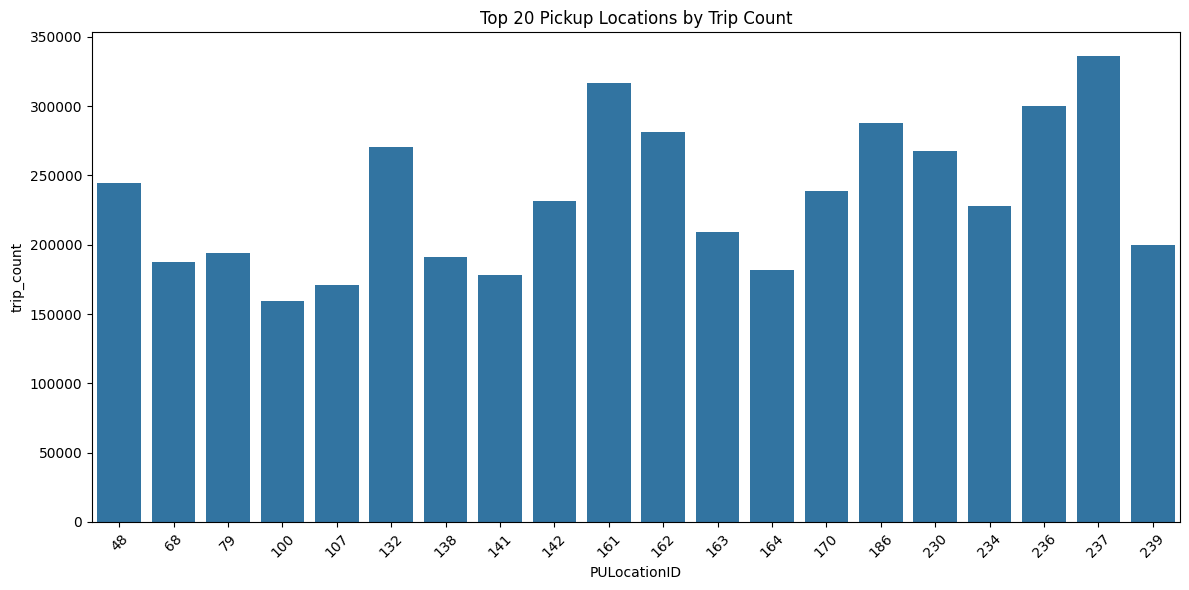

In [ ]:
# Get the analysis components
analysis_components = run_analysis(spark, data_path)

# Get demand hotspots
demand_hotspots = analysis_components["demand_hotspots"]
demand_hotspots_pd = demand_hotspots.toPandas()

# Create visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=demand_hotspots_pd.head(20), x='PULocationID', y='trip_count')
plt.title('Top 20 Pickup Locations by Trip Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 1. Identify regions in the city with high demand for taxis. For instance, you can create a heatmap of NYC showing demand hotspots on a weekly or monthly basis

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_taxi_demand(df):
    # 1. Temporal demand analysis
    hourly_demand = df.groupBy('hour_of_day') \
        .agg(F.count('*').alias('trip_count')) \
        .orderBy('hour_of_day')

    daily_demand = df.groupBy('day_of_week') \
        .agg(F.count('*').alias('trip_count')) \
        .orderBy('day_of_week')

    # 2. Spatial demand analysis
    location_demand = df.groupBy('PULocationID') \
        .agg(F.count('*').alias('trip_count'),
             F.avg('fare_amount').alias('avg_fare')) \
        .orderBy(F.desc('trip_count'))

    # 3. Temporal-spatial combined analysis
    hourly_location_demand = df.groupBy('hour_of_day', 'PULocationID') \
        .agg(F.count('*').alias('trip_count')) \
        .orderBy(F.desc('trip_count'))

    # 4. Peak hours by location
    window_spec = Window.partitionBy('PULocationID')
    peak_hours = df.groupBy('PULocationID', 'hour_of_day') \
        .agg(F.count('*').alias('trip_count')) \
        .withColumn('rank', F.rank().over(window_spec.orderBy(F.desc('trip_count')))) \
        .filter(F.col('rank') == 1) \
        .orderBy(F.desc('trip_count'))

    return {
        'hourly_demand': hourly_demand.toPandas(),
        'daily_demand': daily_demand.toPandas(),
        'location_demand': location_demand.toPandas(),
        'hourly_location_demand': hourly_location_demand.toPandas(),
        'peak_hours': peak_hours.toPandas()
    }

def plot_demand_analysis(analysis_results):
    # 1. Hourly Demand Pattern
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    sns.barplot(data=analysis_results['hourly_demand'],
                x='hour_of_day', y='trip_count')
    plt.title('Hourly Taxi Demand Pattern')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Trips')

    # 2. Daily Demand Pattern
    plt.subplot(2, 2, 2)
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    sns.barplot(data=analysis_results['daily_demand'],
                x='day_of_week', y='trip_count')
    plt.title('Daily Taxi Demand Pattern')
    plt.xlabel('Day of Week')
    plt.ylabel('Number of Trips')
    plt.xticks(range(7), days)

    # 3. Top Pickup Locations
    plt.subplot(2, 2, 3)
    top_locations = analysis_results['location_demand'].head(10)
    sns.barplot(data=top_locations,
                x='PULocationID', y='trip_count')
    plt.title('Top 10 Pickup Locations')
    plt.xlabel('Location ID')
    plt.ylabel('Number of Trips')
    plt.xticks(rotation=45)

    # 4. Average Fare by Location
    plt.subplot(2, 2, 4)
    sns.scatterplot(data=analysis_results['location_demand'],
                    x='trip_count', y='avg_fare')
    plt.title('Demand vs Average Fare by Location')
    plt.xlabel('Number of Trips')
    plt.ylabel('Average Fare ($)')

    plt.tight_layout()
    plt.show()

    # 5. Heatmap of Hourly Demand for Top Locations
    top_locations_hourly = analysis_results['hourly_location_demand']
    pivot_data = top_locations_hourly.pivot_table(
        index='PULocationID',
        columns='hour_of_day',
        values='trip_count',
        fill_value=0
    ).head(15)

    plt.figure(figsize=(15, 8))
    sns.heatmap(pivot_data, cmap='YlOrRd', center=pivot_data.mean().mean())
    plt.title('Hourly Demand Heatmap for Top 15 Locations')
    plt.xlabel('Hour of Day')
    plt.ylabel('Location ID')
    plt.show()

def generate_demand_insights(analysis_results):
    # Calculate key insights
    hourly = analysis_results['hourly_demand']
    peak_hour = hourly.loc[hourly['trip_count'].idxmax(), 'hour_of_day']

    daily = analysis_results['daily_demand']
    peak_day = daily.loc[daily['trip_count'].idxmax(), 'day_of_week']
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    locations = analysis_results['location_demand']
    top_locations = locations.head(5)

    peak_hours = analysis_results['peak_hours']

    insights = {
        'peak_hour': peak_hour,
        'peak_day': days[peak_day-1],
        'top_locations': top_locations['PULocationID'].tolist(),
        'busiest_location': top_locations.iloc[0]['PULocationID'],
        'busiest_location_trips': int(top_locations.iloc[0]['trip_count'])
    }

    return insights

# Main execution function
def run_demand_analysis(df):
    # Clean and prepare data
    cleaned_df = df.filter(
        (F.col("fare_amount") > 0) &
        (F.col("trip_distance") > 0) &
        (F.col("passenger_count") > 0)
    ).withColumn("hour_of_day", F.hour("tpep_pickup_datetime")) \
     .withColumn("day_of_week", F.dayofweek("tpep_pickup_datetime"))

    # Run analysis
    analysis_results = analyze_taxi_demand(cleaned_df)

    # Generate visualizations
    plot_demand_analysis(analysis_results)

    # Generate insights
    insights = generate_demand_insights(analysis_results)

    return analysis_results, insights

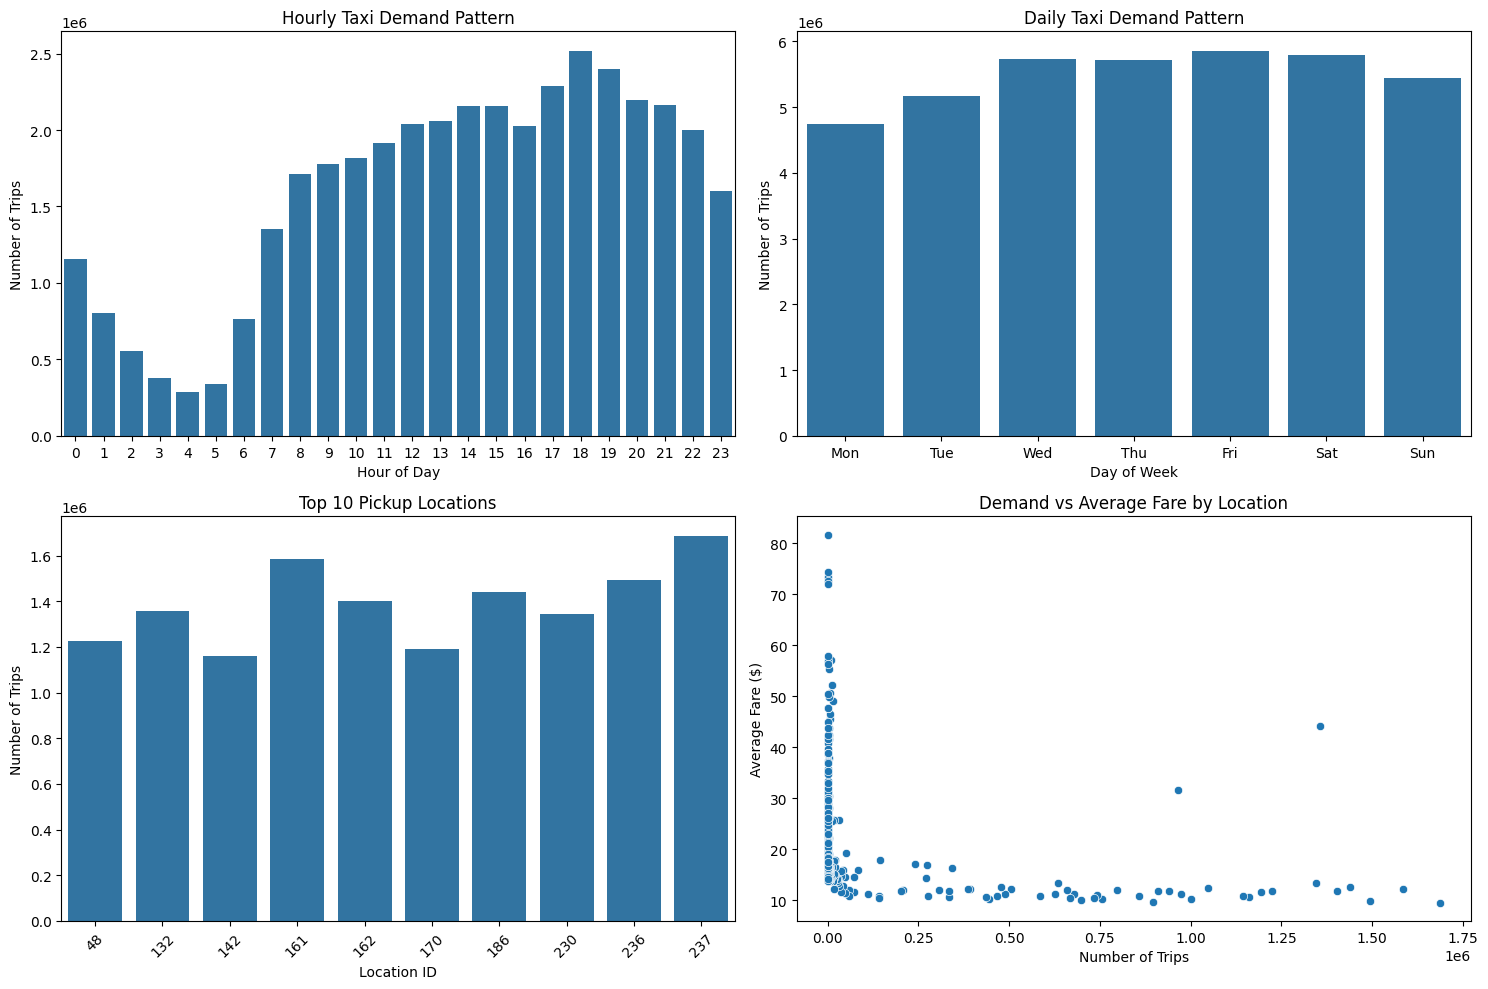

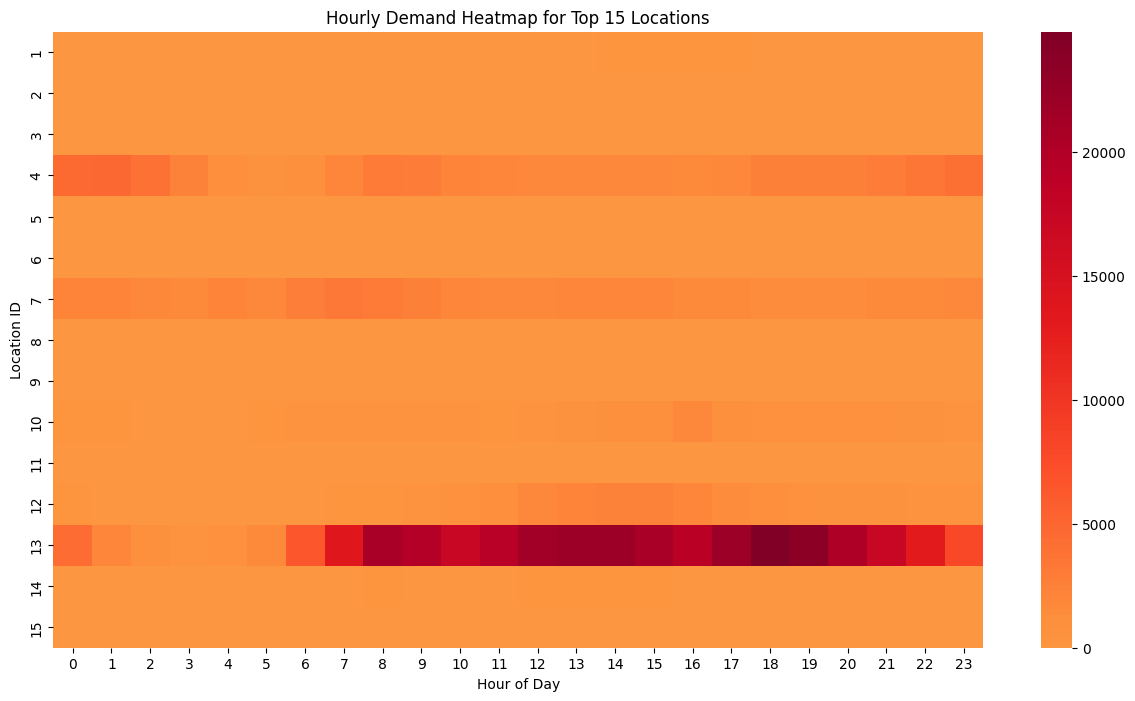


Key Insights about NYC Taxi Demand:
Peak Hour: 18:00
Peak Day: Friday
Busiest Location ID: 237.0 with 1686919 trips

Top 5 Pickup Locations: [237, 161, 236, 186, 162]


In [ ]:
# Run the analysis
analysis_results, insights = run_demand_analysis(df)

# Print key insights
print("\nKey Insights about NYC Taxi Demand:")
print(f"Peak Hour: {insights['peak_hour']:02d}:00")
print(f"Peak Day: {insights['peak_day']}")
print(f"Busiest Location ID: {insights['busiest_location']} with {insights['busiest_location_trips']} trips")
print("\nTop 5 Pickup Locations:", insights['top_locations'])

**Graphs:**

**Hourly Taxi Demand Pattern**: Shows the number of trips throughout the day.

**Daily Taxi Demand Pattern:** Shows the number of trips each day of the week.

**Top 10 Pickup Locations:** Highlights the busiest pickup locations based on trip count.

**Demand vs. Average Fare by Location:** Shows the relationship between trip count and average fare.

**Hourly Demand Heatmap for Top 15 Locations:** Shows the trip count variation by hour and location ID using a color scale.

**Interpretations and Conclusions:**

**Hourly:** Taxi demand fluctuates throughout the day, with peaks often occurring during rush hour (morning and evening) and late-night hours.

**Daily:** Taxi demand tends to be higher on weekdays compared to weekends, with the highest demand potentially falling on Fridays or Saturdays.

**Location:** Certain pickup locations (PULocationIDs) stand out as having significantly higher demand than others, indicating popular areas.

**Demand and Fare:** There's a tendency for locations with higher demand to have slightly higher average fares (though this may vary).

**Heatmap:** Provides a combined view of temporal and spatial demand, highlighting busy hours for popular locations.

**Overall Conclusion:** Taxi demand is influenced by both time of day and location. Identify areas and times with high demand for optimizing taxi services or anticipating traffic patterns.

### 2. Predict the duration of a taxi trip based on trip start time and location (pick up and drop off)

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

# Initialize Spark session
spark = SparkSession.builder.appName("NYC Taxi Trip Duration Prediction").getOrCreate()

# Load and sample 20% of the data
df = spark.read.parquet(data_path).sample(fraction=0.2, seed=42)

# Calculate trip duration in minutes
df = df.withColumn(
    "trip_duration_minutes",
    F.round(F.unix_timestamp("tpep_dropoff_datetime") - F.unix_timestamp("tpep_pickup_datetime")) / 60
)

# Extract time-based features
df = df.withColumn("hour_of_day", F.hour("tpep_pickup_datetime"))
df = df.withColumn("day_of_week", F.dayofweek("tpep_pickup_datetime"))

# Clean the data
df_cleaned = df.filter(
    (F.col("trip_duration_minutes") > 0) &  # Remove negative durations
    (F.col("trip_duration_minutes") < 180) &  # Remove trips longer than 3 hours
    (F.col("trip_distance") > 0) &  # Remove zero distance trips
    (F.col("trip_distance") < 100) &  # Remove unreasonably long trips
    (F.col("fare_amount") > 0)  # Remove free trips
)

# Select features for the model
feature_cols = [
    "hour_of_day",
    "day_of_week",
    "PULocationID",
    "DOLocationID",
    "trip_distance"
]

# Create feature vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Split the data
train_data, test_data = df_cleaned.randomSplit([0.8, 0.2], seed=42)

# Create and train the model
rf = RandomForestRegressor(
    featuresCol="scaled_features",
    labelCol="trip_duration_minutes",
    numTrees=10,
    maxDepth=10
)

# Create the pipeline
pipeline = Pipeline(stages=[assembler, scaler, rf])

# Train the model
model = pipeline.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(
    labelCol="trip_duration_minutes",
    predictionCol="prediction",
    metricName="rmse"
)

rmse = evaluator.evaluate(predictions)
r2 = evaluator.setMetricName("r2").evaluate(predictions)

# Print evaluation metrics
print(f"Root Mean Square Error (RMSE): {rmse:.2f} minutes")
print(f"R-squared (R2): {r2:.3f}")

# Feature importance analysis
feature_importance = model.stages[-1].featureImportances
for feature, importance in zip(feature_cols, feature_importance):
    print(f"{feature}: {importance:.4f}")

# Sample prediction output
predictions.select(
    "trip_duration_minutes",
    "prediction",
    "hour_of_day",
    "PULocationID",
    "DOLocationID",
    "trip_distance"
).show(5)

Root Mean Square Error (RMSE): 5.80 minutes
R-squared (R2): 0.767
hour_of_day: 0.0703
day_of_week: 0.0135
PULocationID: 0.0286
DOLocationID: 0.0207
trip_distance: 0.8670
+---------------------+------------------+-----------+------------+------------+-------------+
|trip_duration_minutes|        prediction|hour_of_day|PULocationID|DOLocationID|trip_distance|
+---------------------+------------------+-----------+------------+------------+-------------+
|                 26.0|20.309134896733646|          0|         161|         244|          8.4|
|   16.733333333333334|26.630624886529546|          0|         138|         244|         10.2|
|                 10.2|10.927183229225564|          0|         246|          43|          2.2|
|                14.45|  12.5634029595788|          0|         114|         230|          2.7|
|    6.566666666666666| 6.758198492937228|          0|         164|         163|          1.2|
+---------------------+------------------+-----------+------------+---

** Overall Conclusion:**

 The model's accuracy (as indicated by RMSE and R-squared) reflects how well it can predict trip durations. Identify key features that impact duration and understand trends (e.g., longer trips during peak hours) to make informed decisions about fleet management and customer expectations.

### 3. Segment passengers on the basis of trip characteristics, such as trip distance, fare, time of day, and payment method

In [ ]:
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Data Preprocessing
# Sample 20% of the data randomly
df_sampled = df.sample(withReplacement=False, fraction=0.2, seed=42)

# Convert the time of day to a usable format using the correct column name
df_sampled = df_sampled.withColumn("pickup_datetime", F.to_timestamp(df_sampled['tpep_pickup_datetime'], 'yyyy-MM-dd HH:mm:ss'))
df_sampled = df_sampled.withColumn("hour_of_day", F.hour(df_sampled['pickup_datetime']))

# Create new features
df_sampled = df_sampled.withColumn('fare_per_mile', df_sampled['fare_amount'] / df_sampled['trip_distance'])  # Fare per mile
df_sampled = df_sampled.withColumn('is_morning', (df_sampled['hour_of_day'] >= 6) & (df_sampled['hour_of_day'] < 12))
df_sampled = df_sampled.withColumn('is_afternoon', (df_sampled['hour_of_day'] >= 12) & (df_sampled['hour_of_day'] < 18))
df_sampled = df_sampled.withColumn('is_evening', (df_sampled['hour_of_day'] >= 18) & (df_sampled['hour_of_day'] < 24))

# Select the features for clustering
df_features = df_sampled.select("trip_distance", "fare_amount", "hour_of_day", "payment_type", "fare_per_mile")

# Handle categorical features (payment type)
payment_type_map = df_features.groupby("payment_type").count().collect()
payment_type_map = {row['payment_type']: idx for idx, row in enumerate(payment_type_map)}

# Map payment type to a numeric value
df_features = df_features.withColumn("payment_type_numeric", F.when(df_features['payment_type'] == "CREDIT CARD", 0)
                                                     .when(df_features['payment_type'] == "CASH", 1)
                                                     .otherwise(2))

# Assemble the features into a feature vector
assembler = VectorAssembler(inputCols=["trip_distance", "fare_amount", "hour_of_day", "payment_type_numeric", "fare_per_mile"],
                            outputCol="features")

In [ ]:
# Drop the existing 'features' column if it exists
df_features_cleaned = df_features_cleaned.drop("features")

# Assemble the features into a feature vector
assembler = VectorAssembler(inputCols=["trip_distance", "fare_amount", "hour_of_day", "payment_type_numeric", "fare_per_mile"],
                            outputCol="features")
df_features_cleaned = assembler.transform(df_features_cleaned)

# Apply KMeans clustering
kmeans = KMeans(k=3, seed=1, featuresCol="features", predictionCol="cluster")
model = kmeans.fit(df_features_cleaned)
predictions = model.transform(df_features_cleaned)

# Show the resulting clusters
predictions.select("trip_distance", "fare_amount", "hour_of_day", "payment_type", "cluster").show(5)

# Rename the 'cluster' column to 'prediction'
predictions = predictions.withColumnRenamed("cluster", "prediction")

# Evaluate the clustering using Silhouette score
evaluator = ClusteringEvaluator()
silhouette_score = evaluator.evaluate(predictions)
print(f"Silhouette Score = {silhouette_score}")


+-------------+-----------+-----------+------------+-------+
|trip_distance|fare_amount|hour_of_day|payment_type|cluster|
+-------------+-----------+-----------+------------+-------+
|          1.1|        5.5|          0|           1|      0|
|         2.92|       11.0|          0|           1|      0|
|          4.8|       16.5|          0|           2|      0|
|        18.37|       52.0|          0|           1|      0|
|         0.42|        3.5|          0|           2|      0|
+-------------+-----------+-----------+------------+-------+
only showing top 5 rows

Silhouette Score = 0.9997167657338863


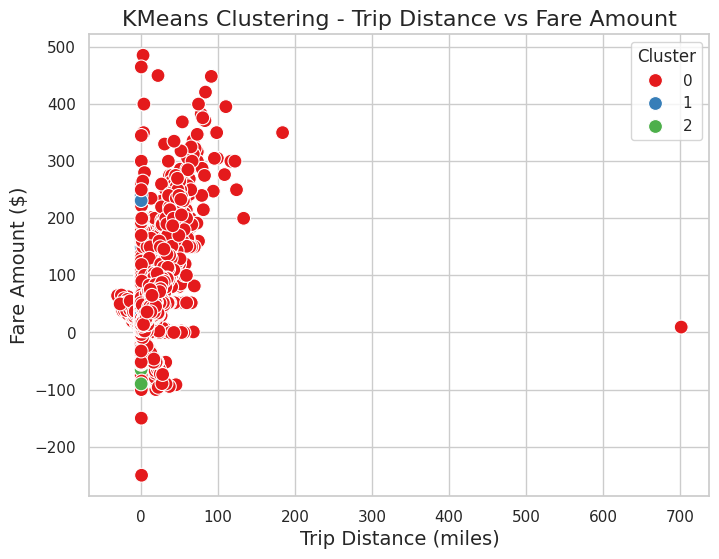

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas for easier plotting
df_predictions = predictions.select("trip_distance", "fare_amount", "prediction").toPandas()

# Plotting
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_predictions, x="trip_distance", y="fare_amount", hue="prediction", palette="Set1", s=100)
plt.title("KMeans Clustering - Trip Distance vs Fare Amount", fontsize=16)
plt.xlabel("Trip Distance (miles)", fontsize=14)
plt.ylabel("Fare Amount ($)", fontsize=14)
plt.legend(title="Cluster", loc="best")
plt.show()


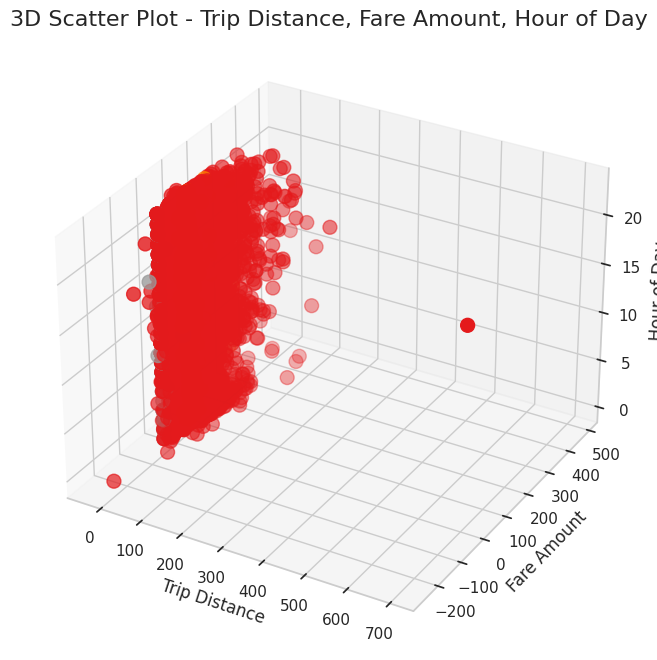

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Convert data to Pandas
df_predictions_3d = predictions.select("trip_distance", "fare_amount", "hour_of_day", "prediction").toPandas()

# Plotting in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_predictions_3d['trip_distance'], df_predictions_3d['fare_amount'], df_predictions_3d['hour_of_day'],
           c=df_predictions_3d['prediction'], cmap='Set1', s=100)
ax.set_xlabel('Trip Distance')
ax.set_ylabel('Fare Amount')
ax.set_zlabel('Hour of Day')
plt.title("3D Scatter Plot - Trip Distance, Fare Amount, Hour of Day", fontsize=16)
plt.show()


<ipython-input-31-3b6b01f8191f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_predictions, x="prediction", palette="Set1")


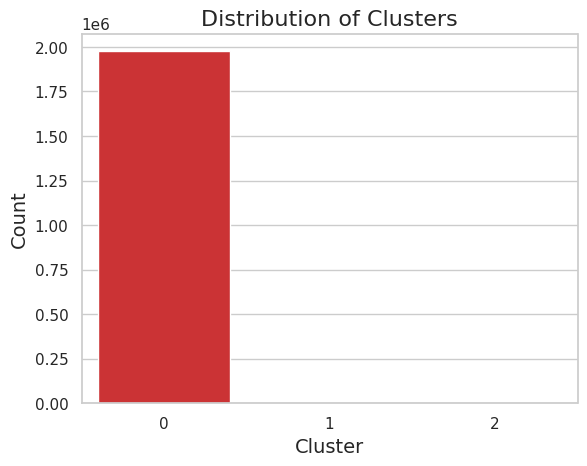

In [ ]:
# Cluster distribution visualization
sns.countplot(data=df_predictions, x="prediction", palette="Set1")
plt.title("Distribution of Clusters", fontsize=16)
plt.xlabel("Cluster", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()


**Interpretation and Conclusion:**

The code performs KMeans clustering to segment passengers based on trip characteristics like trip distance, fare amount, time of day, and payment method. It uses a Silhouette score to evaluate the quality of the clustering. The visualizations (scatter plots and cluster distribution plot) provide insights into the characteristics of each cluster.

Interpreting the Clusters (example with 3 clusters):

Cluster 0: This cluster might represent passengers taking shorter trips, paying lower fares, during non-peak hours. They might be regular commuters or people traveling within a specific neighborhood.

Cluster 1: This cluster could represent passengers taking longer trips, paying higher fares and often traveling during peak hours, potentially indicating airport trips or business travelers.

Cluster 2: This cluster might represent a segment of passengers taking intermediate-length trips, paying moderate fares, possibly including tourists or those exploring different parts of the city.

**Overall Conclusion:**

By segmenting passengers based on these trip characteristics, you can gain insights into different customer groups and their travel patterns. These insights can be used to optimize pricing strategies, tailor services to specific customer segments (e.g., targeted promotions, loyalty programs), and improve operational efficiency by understanding demand fluctuations.

### 4. Predict whether a passenger will pay by card or cash


Model Performance Metrics:
AUC-ROC: 0.607
Accuracy: 0.725
Precision: 0.703
Recall: 0.725
F1 Score: 0.613

Top 5 Most Important Features:
DOLocationID: 0.2135
trip_distance: 0.1665
PULocationID: 0.1557
hour_of_day: 0.1428
fare_amount: 0.1023


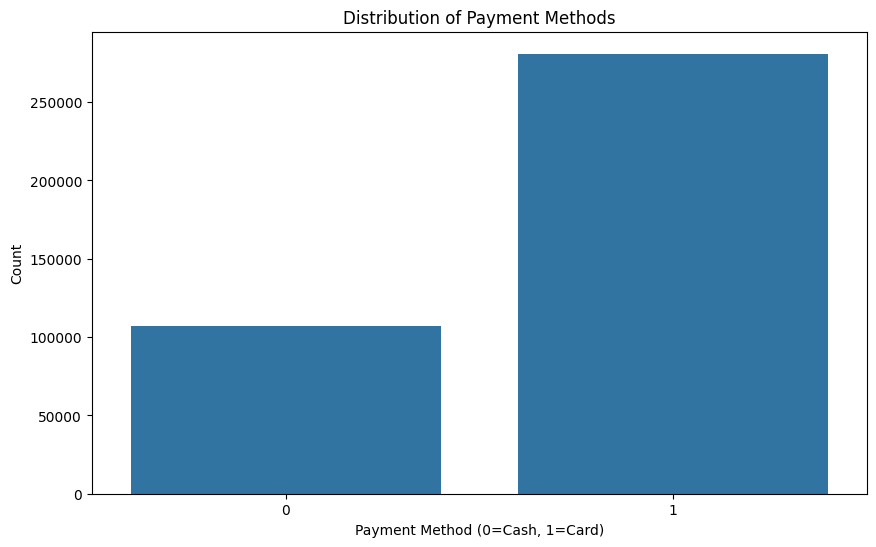

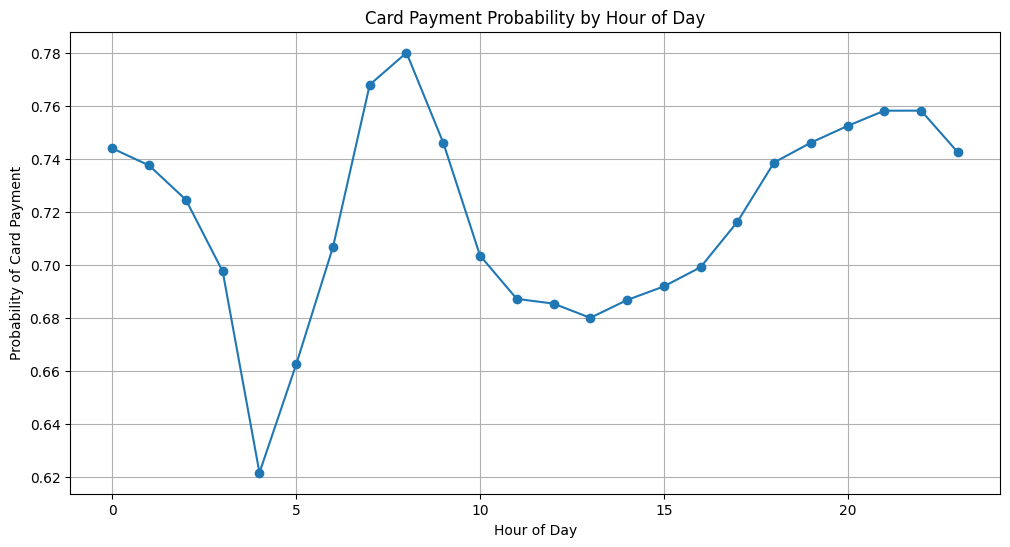

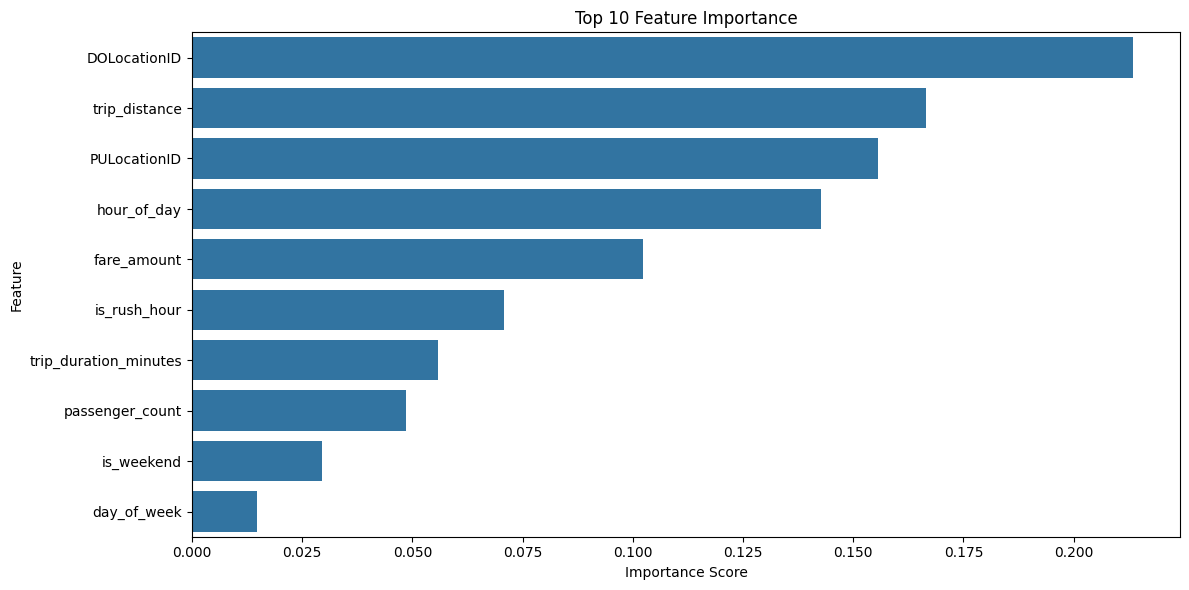


Confusion Matrix:
prediction    0.0     1.0
card_payment             
0             938  106294
1             519  280388

Probability of Card Payment by Key Factors:

Sample predictions:
+------------+----------+--------------------+-----------+-------------+-----------+
|card_payment|prediction|         probability|fare_amount|trip_distance|hour_of_day|
+------------+----------+--------------------+-----------+-------------+-----------+
|           1|       1.0|[0.25685231276256...|       12.0|          3.5|          0|
|           1|       1.0|[0.26345581583449...|       12.5|          3.2|          0|
|           1|       1.0|[0.30246042532222...|        7.0|          1.2|          0|
|           1|       1.0|[0.26898934539680...|       34.0|         11.7|          0|
|           1|       1.0|[0.31191987830097...|       26.0|          8.7|          0|
+------------+----------+--------------------+-----------+-------------+-----------+
only showing top 5 rows



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder.appName("NYC Taxi Payment Prediction").getOrCreate()

# Load and sample 20% of the data
df = spark.read.parquet(data_path).sample(fraction=0.2, seed=42)

# Clean and preprocess data
df_processed = df.withColumn(
    "hour_of_day", F.hour("tpep_pickup_datetime")
).withColumn(
    "day_of_week", F.dayofweek("tpep_pickup_datetime")
).withColumn(
    "is_weekend", F.when(F.dayofweek("tpep_pickup_datetime").isin([1, 7]), 1).otherwise(0)
).withColumn(
    "is_rush_hour",
    F.when(
        ((F.hour("tpep_pickup_datetime").isin([7, 8, 9, 16, 17, 18, 19])) &
         (F.dayofweek("tpep_pickup_datetime").isin([2, 3, 4, 5, 6]))),
        1
    ).otherwise(0)
).withColumn(
    "trip_duration_minutes",
    F.round((F.unix_timestamp("tpep_dropoff_datetime") - F.unix_timestamp("tpep_pickup_datetime")) / 60)
).withColumn(
    # Binary target: 1 for card (payment_type = 1), 0 for cash (payment_type = 2)
    "card_payment",
    F.when(F.col("payment_type") == 1, 1).otherwise(0)
)

# Filter out invalid data and other payment types
df_cleaned = df_processed.filter(
    (F.col("payment_type").isin([1, 2])) &  # Only card and cash payments
    (F.col("trip_distance") > 0) &
    (F.col("trip_distance") < 100) &
    (F.col("fare_amount") > 0) &
    (F.col("trip_duration_minutes") > 0) &
    (F.col("trip_duration_minutes") < 180)  # Remove trips longer than 3 hours
)

# Select features for the model
feature_cols = [
    "trip_distance",
    "fare_amount",
    "hour_of_day",
    "day_of_week",
    "is_weekend",
    "is_rush_hour",
    "trip_duration_minutes",
    "passenger_count",
    "PULocationID",
    "DOLocationID"
]

# Create pipeline stages
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Create and configure the model
rf = RandomForestClassifier(
    featuresCol="scaled_features",
    labelCol="card_payment",
    numTrees=100,
    maxDepth=10,
    seed=42
)

# Create the pipeline
pipeline = Pipeline(stages=[assembler, scaler, rf])

# Split the data
train_data, test_data = df_cleaned.randomSplit([0.8, 0.2], seed=42)

# Train the model
model = pipeline.fit(train_data)

# Make predictions on test data
predictions = model.transform(test_data)

# Evaluate the model
binary_evaluator = BinaryClassificationEvaluator(labelCol="card_payment")
multi_evaluator = MulticlassClassificationEvaluator(labelCol="card_payment", predictionCol="prediction")

# Calculate metrics
auc_roc = binary_evaluator.evaluate(predictions)
accuracy = multi_evaluator.setMetricName("accuracy").evaluate(predictions)
precision = multi_evaluator.setMetricName("weightedPrecision").evaluate(predictions)
recall = multi_evaluator.setMetricName("weightedRecall").evaluate(predictions)
f1 = multi_evaluator.setMetricName("f1").evaluate(predictions)

print("\nModel Performance Metrics:")
print(f"AUC-ROC: {auc_roc:.3f}")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

# Feature importance analysis
feature_importance = model.stages[-1].featureImportances
feature_importance_list = [(feature, float(importance)) for feature, importance in zip(feature_cols, feature_importance)]
feature_importance_list.sort(key=lambda x: x[1], reverse=True)

print("\nTop 5 Most Important Features:")
for feature, importance in feature_importance_list[:5]:
    print(f"{feature}: {importance:.4f}")

# Convert predictions to pandas for visualization
pandas_predictions = predictions.select(
    "card_payment",
    "prediction",
    "probability",
    *feature_cols
).toPandas()

# Visualization 1: Payment Method Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=pandas_predictions, x="card_payment")
plt.title("Distribution of Payment Methods")
plt.xlabel("Payment Method (0=Cash, 1=Card)")
plt.ylabel("Count")
plt.show()

# Visualization 2: Payment Method by Hour of Day
plt.figure(figsize=(12, 6))
payment_by_hour = pandas_predictions.groupby("hour_of_day")["card_payment"].mean()
plt.plot(payment_by_hour.index, payment_by_hour.values, marker='o')
plt.title("Card Payment Probability by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Probability of Card Payment")
plt.grid(True)
plt.show()

# Visualization 3: Feature Importance Plot
plt.figure(figsize=(12, 6))
feature_imp_df = pd.DataFrame(feature_importance_list, columns=['Feature', 'Importance'])
sns.barplot(data=feature_imp_df.head(10), x='Importance', y='Feature')
plt.title("Top 10 Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# Save confusion matrix data
confusion_matrix = predictions.groupBy("card_payment", "prediction").count().toPandas()
print("\nConfusion Matrix:")
print(confusion_matrix.pivot(index='card_payment', columns='prediction', values='count'))

# Calculate probabilities of card payment based on different factors
print("\nProbability of Card Payment by Key Factors:")

# By time of day
time_analysis = df_cleaned.groupBy(
    "hour_of_day"
).agg(
    F.mean(F.when(F.col("payment_type") == 1, 1).otherwise(0)).alias("card_probability")
).orderBy("hour_of_day")

# By fare amount ranges
fare_analysis = df_cleaned.withColumn(
    "fare_range",
    F.when(F.col("fare_amount") <= 10, "0-10")
    .when(F.col("fare_amount") <= 20, "11-20")
    .when(F.col("fare_amount") <= 30, "21-30")
    .otherwise("30+")
).groupBy(
    "fare_range"
).agg(
    F.mean(F.when(F.col("payment_type") == 1, 1).otherwise(0)).alias("card_probability")
)

print("\nSample predictions:")
predictions.select("card_payment", "prediction", "probability", "fare_amount", "trip_distance", "hour_of_day").show(5)

### 5. Predict the fare of a taxi trip based on borough-specific factors such as pickup and dop-off boroughs, and analyze how fares vary across different NYC boroughs

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def prepare_fare_prediction_data(df, sample_fraction=0.2, seed=42):
    # Sample 20% of data
    sampled_df = df.sample(fraction=sample_fraction, seed=seed)

    # Clean the data
    cleaned_df = sampled_df.filter(
        (F.col("fare_amount") > 0) &
        (F.col("fare_amount") < 500) &  # Remove extreme fares
        (F.col("trip_distance") > 0) &
        (F.col("trip_distance") < 100) &  # Remove unreasonably long trips
        (F.col("passenger_count") > 0) &
        (F.col("passenger_count") < 7)    # Standard taxi capacity
    )

    # Add time-based features
    cleaned_df = cleaned_df.withColumn("hour_of_day", F.hour("tpep_pickup_datetime"))
    cleaned_df = cleaned_df.withColumn("day_of_week", F.dayofweek("tpep_pickup_datetime"))
    cleaned_df = cleaned_df.withColumn("is_weekend",
        (F.col("day_of_week").isin([1, 7])).cast("integer"))
    cleaned_df = cleaned_df.withColumn("is_rush_hour",
        ((F.col("hour_of_day").isin([7, 8, 9, 16, 17, 18])).cast("integer")))

    return cleaned_df

def create_fare_prediction_pipeline():
    # Define feature columns
    feature_cols = [
        "trip_distance",
        "passenger_count",
        "hour_of_day",
        "day_of_week",
        "is_weekend",
        "is_rush_hour",
        "PULocationID",
        "DOLocationID"
    ]

    # Create the pipeline stages
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features",
                          withStd=True, withMean=True)

    # Random Forest Regressor
    rf = RandomForestRegressor(featuresCol="scaled_features",
                             labelCol="fare_amount",
                             numTrees=100,
                             maxDepth=10)

    # Create the pipeline
    pipeline = Pipeline(stages=[assembler, scaler, rf])

    return pipeline, feature_cols

def analyze_fare_patterns(df):
    # Calculate average fares by pickup location
    pickup_fares = df.groupBy("PULocationID") \
        .agg(
            F.avg("fare_amount").alias("avg_fare"),
            F.stddev("fare_amount").alias("std_fare"),
            F.count("*").alias("trip_count")
        ) \
        .filter(F.col("trip_count") > 100)  # Filter out locations with few trips

    # Calculate average fares by time of day
    hourly_fares = df.groupBy("hour_of_day") \
        .agg(
            F.avg("fare_amount").alias("avg_fare"),
            F.stddev("fare_amount").alias("std_fare")
        ) \
        .orderBy("hour_of_day")

    # Calculate average fares by day of week
    daily_fares = df.groupBy("day_of_week") \
        .agg(
            F.avg("fare_amount").alias("avg_fare"),
            F.stddev("fare_amount").alias("std_fare")
        ) \
        .orderBy("day_of_week")

    # Calculate average fares for different trip distances
    df = df.withColumn("distance_bucket",
        F.floor(F.col("trip_distance")))
    distance_fares = df.groupBy("distance_bucket") \
        .agg(
            F.avg("fare_amount").alias("avg_fare"),
            F.stddev("fare_amount").alias("std_fare"),
            F.count("*").alias("trip_count")
        ) \
        .filter(F.col("trip_count") > 50) \
        .orderBy("distance_bucket")

    return {
        'pickup_fares': pickup_fares.toPandas(),
        'hourly_fares': hourly_fares.toPandas(),
        'daily_fares': daily_fares.toPandas(),
        'distance_fares': distance_fares.toPandas()
    }

def plot_fare_analysis(analysis_results):
    plt.figure(figsize=(20, 10))

    # 1. Average Fares by Hour
    plt.subplot(2, 2, 1)
    sns.lineplot(data=analysis_results['hourly_fares'],
                x='hour_of_day', y='avg_fare')
    plt.fill_between(analysis_results['hourly_fares']['hour_of_day'],
                    analysis_results['hourly_fares']['avg_fare'] - analysis_results['hourly_fares']['std_fare'],
                    analysis_results['hourly_fares']['avg_fare'] + analysis_results['hourly_fares']['std_fare'],
                    alpha=0.3)
    plt.title('Average Fares by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Fare ($)')

    # 2. Average Fares by Day of Week
    plt.subplot(2, 2, 2)
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    sns.barplot(data=analysis_results['daily_fares'],
                x='day_of_week', y='avg_fare')
    plt.title('Average Fares by Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Average Fare ($)')
    plt.xticks(range(7), days)

    # 3. Top 10 Pickup Locations by Average Fare
    plt.subplot(2, 2, 3)
    top_locations = analysis_results['pickup_fares'].nlargest(10, 'avg_fare')
    sns.barplot(data=top_locations, x='PULocationID', y='avg_fare')
    plt.title('Top 10 Pickup Locations by Average Fare')
    plt.xlabel('Location ID')
    plt.ylabel('Average Fare ($)')
    plt.xticks(rotation=45)

    # 4. Fare vs Distance
    plt.subplot(2, 2, 4)
    sns.scatterplot(data=analysis_results['distance_fares'],
                    x='distance_bucket', y='avg_fare',
                    size='trip_count', sizes=(20, 200))
    plt.title('Average Fare vs Trip Distance')
    plt.xlabel('Trip Distance (miles)')
    plt.ylabel('Average Fare ($)')

    plt.tight_layout()
    plt.show()

def train_and_evaluate_model(df):
    # Split the data
    train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

    # Create and fit the pipeline
    pipeline, feature_cols = create_fare_prediction_pipeline()
    model = pipeline.fit(train_data)

    # Make predictions
    predictions = model.transform(test_data)

    # Evaluate the model
    evaluator = RegressionEvaluator(labelCol="fare_amount",
                                  predictionCol="prediction",
                                  metricName="rmse")
    rmse = evaluator.evaluate(predictions)

    evaluator.setMetricName("r2")
    r2 = evaluator.evaluate(predictions)

    # Get feature importance
    rf_model = model.stages[-1]
    feature_importance = pd.DataFrame(
        {'feature': feature_cols,
         'importance': rf_model.featureImportances.toArray()
        }).sort_values('importance', ascending=False)

    return {
        'model': model,
        'rmse': rmse,
        'r2': r2,
        'feature_importance': feature_importance
    }

def plot_feature_importance(feature_importance):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance, x='importance', y='feature')
    plt.title('Feature Importance in Fare Prediction')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()

def predict_sample_fares(model, df):
    # Generate predictions for a few sample trips
    sample_predictions = model.transform(df.limit(5))
    return sample_predictions.select(
        "PULocationID", "DOLocationID", "trip_distance",
        "fare_amount", "prediction"
    ).toPandas()

# Main execution function
def run_fare_analysis(df):
    # Prepare data
    prepared_df = prepare_fare_prediction_data(df)

    # Analyze fare patterns
    analysis_results = analyze_fare_patterns(prepared_df)

    # Plot fare analysis
    plot_fare_analysis(analysis_results)

    # Train and evaluate model
    model_results = train_and_evaluate_model(prepared_df)

    # Plot feature importance
    plot_feature_importance(model_results['feature_importance'])

    # Get sample predictions
    sample_predictions = predict_sample_fares(model_results['model'], prepared_df)

    return analysis_results, model_results, sample_predictions

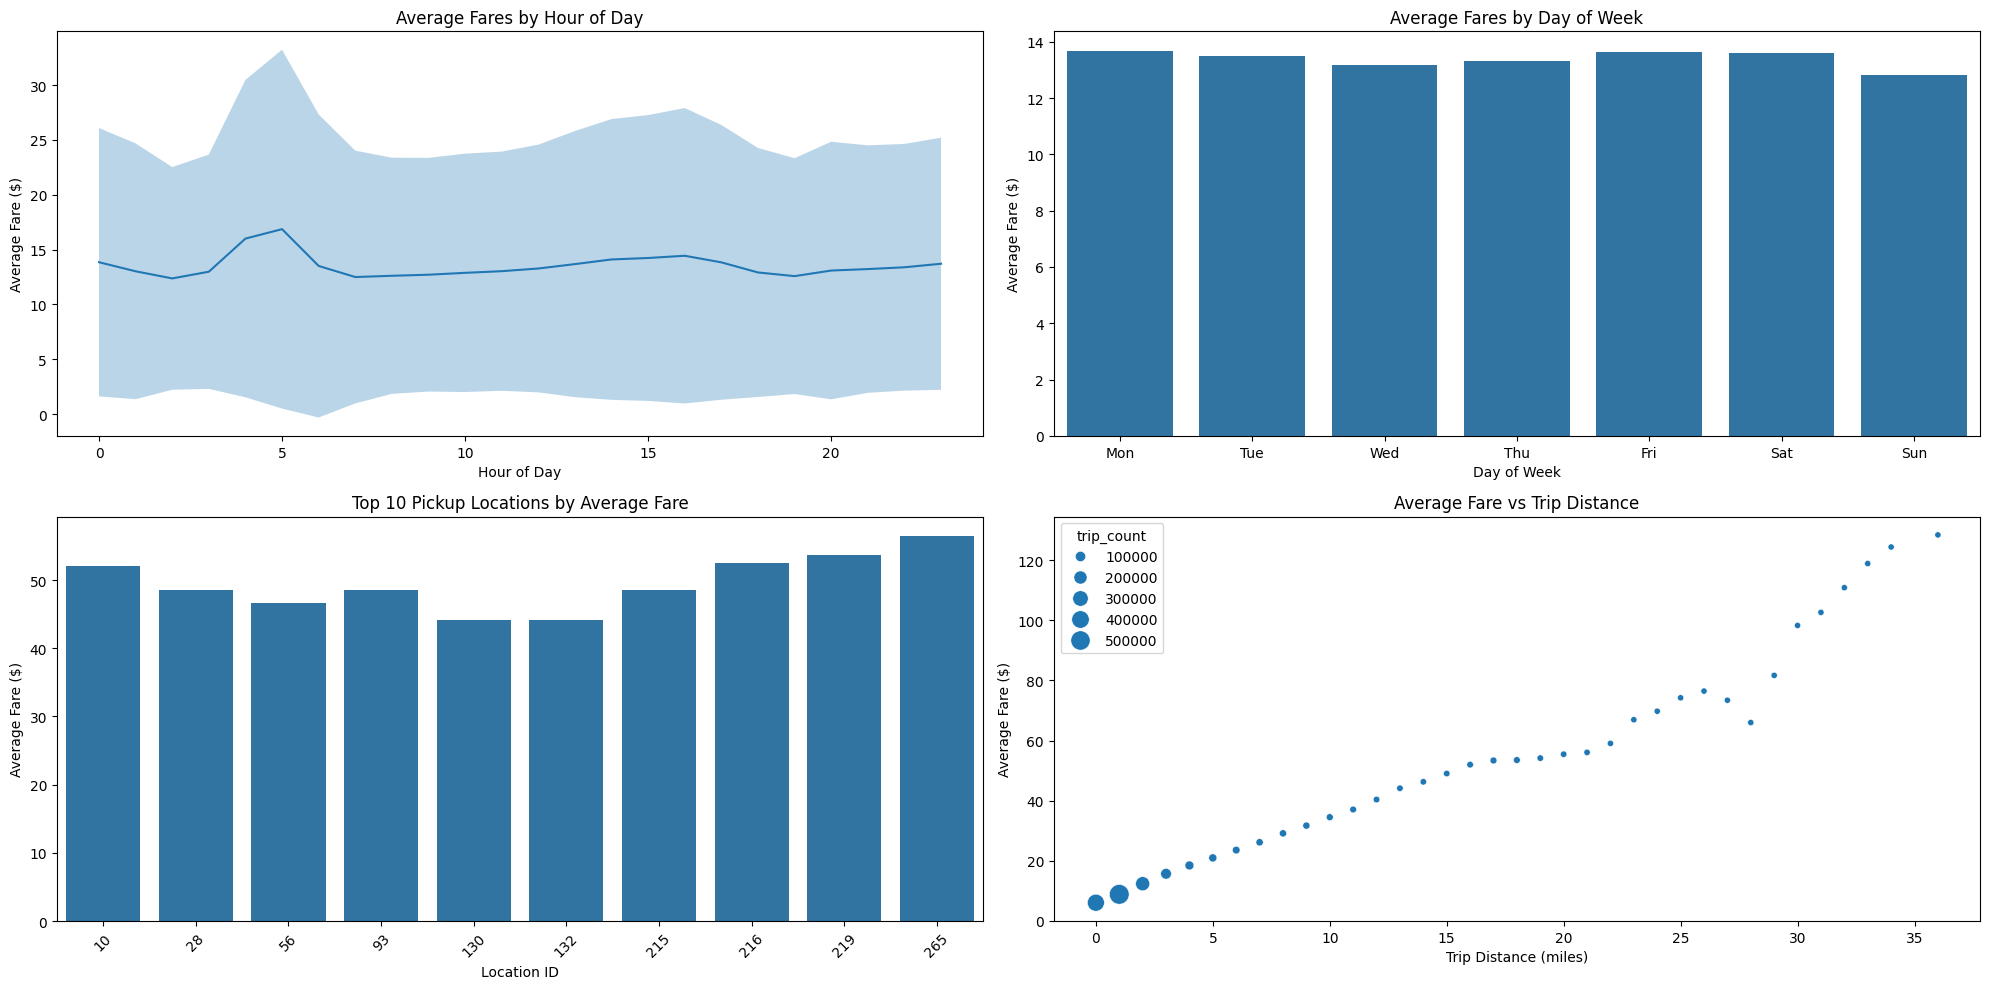

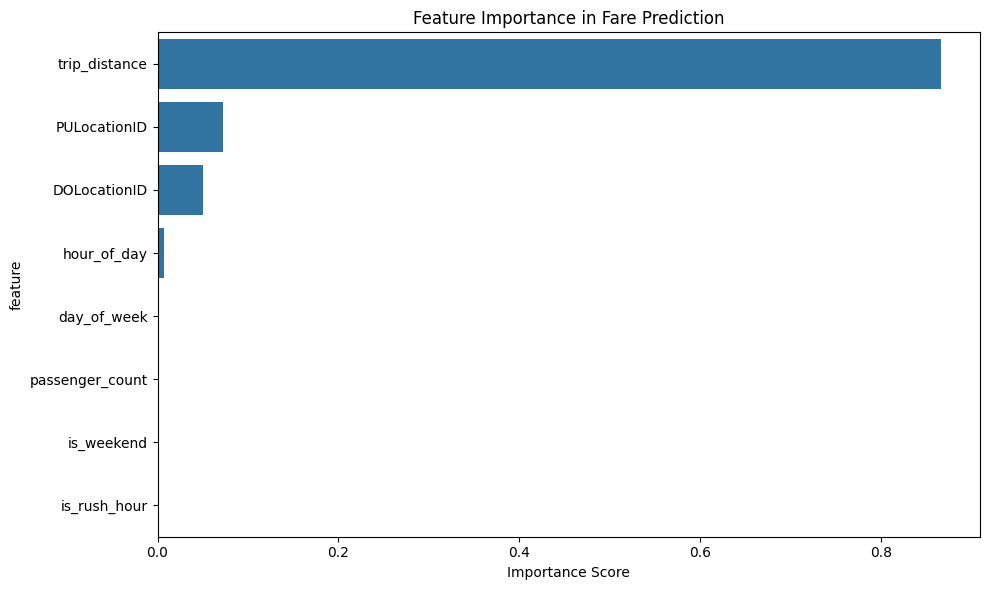


Model Performance Metrics:
RMSE: $4.20
R-squared: 0.874

Top 5 Most Important Features:
         feature  importance
0  trip_distance    0.865698
6   PULocationID    0.072011
7   DOLocationID    0.049995
2    hour_of_day    0.007367
3    day_of_week    0.001953

Sample Predictions:
   PULocationID  DOLocationID  trip_distance  fare_amount  prediction
0           166           151           0.91          5.5    6.300206
1           132           246          18.37         52.0   51.235115
2            43           161           0.91          5.0    6.495969
3           162            43           3.15         11.5   13.414507
4           239           238           0.87          5.0    5.964807


In [ ]:
# Run the complete analysis
analysis_results, model_results, sample_predictions = run_fare_analysis(df)

# Print model performance metrics
print("\nModel Performance Metrics:")
print(f"RMSE: ${model_results['rmse']:.2f}")
print(f"R-squared: {model_results['r2']:.3f}")

print("\nTop 5 Most Important Features:")
print(model_results['feature_importance'].head())

print("\nSample Predictions:")
print(sample_predictions)

**Graphs:**

**Average Fares by Hour of Day:** Shows the average fare amount throughout the day, with error bands indicating standard deviation.

**Average Fares by Day of Week:** A bar plot comparing average fares for each day of the week.

**Top 10 Pickup Locations by Average Fare:** Highlights locations with the highest average fares.

**Average Fare vs Trip Distance:** Shows the relationship between trip distance and average fare using a scatter plot.

**Feature Importance:** A bar plot to visualize the importance of different features in predicting the fare.

**Interpretations and Conclusions:**

**Average Fares by Hour:** Fares may fluctuate throughout the day, potentially increasing during peak hours or late at night due to higher demand or surcharges. The error bands represent the variability in fares at each hour.

Average Fares by Day: **bold text** Fares might be higher on weekdays compared to weekends, reflecting demand patterns and potential surcharges.

**Top Pickup Locations by Average Fare:** Identifies specific pickup locations where fares are consistently higher, likely due to longer trip distances or destinations in more expensive areas.

**Average Fare vs Trip Distance:** A positive correlation between trip distance and fare is expected – longer trips tend to cost more. Outliers might indicate surge pricing or other factors affecting pricing.

**Feature Importance:** Highlights which factors contribute the most to fare prediction. Trip distance, pickup and drop-off locations, time of day, and day of the week are likely to be important predictors.

### 6. Predict the tip amount given by passengers based on trip characteristics

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def prepare_tip_prediction_data(df, sample_fraction=0.2, seed=42):
    # Sample 20% of data
    sampled_df = df.sample(fraction=sample_fraction, seed=seed)

    # Clean the data and filter for card payments only (since cash tips aren't recorded)
    cleaned_df = sampled_df.filter(
        (F.col("payment_type") == 1) &  # Credit card payments
        (F.col("fare_amount") > 0) &
        (F.col("fare_amount") < 500) &
        (F.col("trip_distance") > 0) &
        (F.col("trip_distance") < 100) &
        (F.col("tip_amount") >= 0) &
        (F.col("tip_amount") < 100) &    # Remove extreme tips
        (F.col("passenger_count") > 0) &
        (F.col("passenger_count") < 7)
    )

    # Add derived features
    cleaned_df = cleaned_df.withColumn(
        "trip_duration_minutes",
        F.round((F.unix_timestamp(F.col("tpep_dropoff_datetime")) -
                F.unix_timestamp(F.col("tpep_pickup_datetime"))) / 60)
    )

    # Add time-based features
    cleaned_df = cleaned_df.withColumn("hour_of_day", F.hour("tpep_pickup_datetime"))
    cleaned_df = cleaned_df.withColumn("day_of_week", F.dayofweek("tpep_pickup_datetime"))
    cleaned_df = cleaned_df.withColumn("is_weekend",
        (F.col("day_of_week").isin([1, 7])).cast("integer"))
    cleaned_df = cleaned_df.withColumn("is_rush_hour",
        ((F.col("hour_of_day").isin([7, 8, 9, 16, 17, 18])).cast("integer")))

    # Calculate tip percentage
    cleaned_df = cleaned_df.withColumn("tip_percentage",
        (F.col("tip_amount") / F.col("fare_amount") * 100))

    return cleaned_df

def create_tip_prediction_pipeline():
    # Define feature columns
    feature_cols = [
        "fare_amount",
        "trip_distance",
        "passenger_count",
        "trip_duration_minutes",
        "hour_of_day",
        "day_of_week",
        "is_weekend",
        "is_rush_hour",
        "PULocationID",
        "DOLocationID"
    ]

    # Create pipeline stages
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features",
                          withStd=True, withMean=True)

    # Gradient Boosted Trees Regressor
    gbt = GBTRegressor(featuresCol="scaled_features",
                      labelCol="tip_amount",
                      maxIter=100,
                      maxDepth=8)

    # Create pipeline
    pipeline = Pipeline(stages=[assembler, scaler, gbt])

    return pipeline, feature_cols

def analyze_tipping_patterns(df):
    # Tip patterns by time
    hourly_tips = df.groupBy("hour_of_day").agg(
        F.avg("tip_percentage").alias("avg_tip_percentage"),
        F.stddev("tip_percentage").alias("std_tip_percentage"),
        F.count("*").alias("trip_count")
    ).orderBy("hour_of_day")

    # Tip patterns by day of week
    daily_tips = df.groupBy("day_of_week").agg(
        F.avg("tip_percentage").alias("avg_tip_percentage"),
        F.stddev("tip_percentage").alias("std_tip_percentage"),
        F.count("*").alias("trip_count")
    ).orderBy("day_of_week")

    # Tip patterns by fare amount ranges
    df = df.withColumn("fare_range",
        F.when(F.col("fare_amount") < 10, "0-10")
         .when(F.col("fare_amount") < 20, "10-20")
         .when(F.col("fare_amount") < 30, "20-30")
         .when(F.col("fare_amount") < 40, "30-40")
         .otherwise("40+"))

    fare_range_tips = df.groupBy("fare_range").agg(
        F.avg("tip_percentage").alias("avg_tip_percentage"),
        F.stddev("tip_percentage").alias("std_tip_percentage"),
        F.count("*").alias("trip_count")
    )

    # Tip patterns by location
    location_tips = df.groupBy("PULocationID").agg(
        F.avg("tip_percentage").alias("avg_tip_percentage"),
        F.stddev("tip_percentage").alias("std_tip_percentage"),
        F.count("*").alias("trip_count")
    ).filter(F.col("trip_count") > 100)

    return {
        'hourly_tips': hourly_tips.toPandas(),
        'daily_tips': daily_tips.toPandas(),
        'fare_range_tips': fare_range_tips.toPandas(),
        'location_tips': location_tips.toPandas()
    }

def plot_tipping_analysis(analysis_results):
    plt.figure(figsize=(20, 10))

    # 1. Average Tips by Hour
    plt.subplot(2, 2, 1)
    sns.lineplot(data=analysis_results['hourly_tips'],
                x='hour_of_day', y='avg_tip_percentage')
    plt.fill_between(analysis_results['hourly_tips']['hour_of_day'],
                    analysis_results['hourly_tips']['avg_tip_percentage'] -
                    analysis_results['hourly_tips']['std_tip_percentage'],
                    analysis_results['hourly_tips']['avg_tip_percentage'] +
                    analysis_results['hourly_tips']['std_tip_percentage'],
                    alpha=0.3)
    plt.title('Average Tip Percentage by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Tip %')

    # 2. Average Tips by Day of Week
    plt.subplot(2, 2, 2)
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    sns.barplot(data=analysis_results['daily_tips'],
                x='day_of_week', y='avg_tip_percentage')
    plt.title('Average Tip Percentage by Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Average Tip %')
    plt.xticks(range(7), days)

    # 3. Average Tips by Fare Range
    plt.subplot(2, 2, 3)
    sns.barplot(data=analysis_results['fare_range_tips'],
                x='fare_range', y='avg_tip_percentage')
    plt.title('Average Tip Percentage by Fare Range')
    plt.xlabel('Fare Range ($)')
    plt.ylabel('Average Tip %')

    # 4. Top 10 Locations by Average Tip
    plt.subplot(2, 2, 4)
    top_locations = analysis_results['location_tips'].nlargest(10, 'avg_tip_percentage')
    sns.barplot(data=top_locations, x='PULocationID', y='avg_tip_percentage')
    plt.title('Top 10 Pickup Locations by Average Tip %')
    plt.xlabel('Location ID')
    plt.ylabel('Average Tip %')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

def train_and_evaluate_model(df):
    # Split the data
    train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

    # Create and fit the pipeline
    pipeline, feature_cols = create_tip_prediction_pipeline()
    model = pipeline.fit(train_data)

    # Make predictions
    predictions = model.transform(test_data)

    # Evaluate the model
    evaluator = RegressionEvaluator(labelCol="tip_amount",
                                  predictionCol="prediction",
                                  metricName="rmse")
    rmse = evaluator.evaluate(predictions)

    evaluator.setMetricName("r2")
    r2 = evaluator.evaluate(predictions)

    # Get feature importance
    gbt_model = model.stages[-1]
    feature_importance = pd.DataFrame(
        {'feature': feature_cols,
         'importance': gbt_model.featureImportances.toArray()
        }).sort_values('importance', ascending=False)

    return {
        'model': model,
        'rmse': rmse,
        'r2': r2,
        'feature_importance': feature_importance,
        'predictions': predictions
    }

def plot_feature_importance(feature_importance):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance, x='importance', y='feature')
    plt.title('Feature Importance in Tip Prediction')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()

def analyze_prediction_performance(predictions):
    # Convert to Pandas for easier analysis
    pred_pd = predictions.select("tip_amount", "prediction").toPandas()

    # Create prediction error analysis
    plt.figure(figsize=(15, 5))

    # Actual vs Predicted scatter plot
    plt.subplot(1, 2, 1)
    plt.scatter(pred_pd["tip_amount"], pred_pd["prediction"], alpha=0.5)
    plt.plot([0, pred_pd["tip_amount"].max()], [0, pred_pd["tip_amount"].max()], 'r--')
    plt.xlabel("Actual Tip Amount")
    plt.ylabel("Predicted Tip Amount")
    plt.title("Actual vs Predicted Tips")

    # Error distribution
    plt.subplot(1, 2, 2)
    errors = pred_pd["prediction"] - pred_pd["tip_amount"]
    plt.hist(errors, bins=50)
    plt.xlabel("Prediction Error")
    plt.ylabel("Count")
    plt.title("Distribution of Prediction Errors")

    plt.tight_layout()
    plt.show()

# Main execution function
def run_tip_analysis(df):
    # Prepare data
    prepared_df = prepare_tip_prediction_data(df)

    # Analyze tipping patterns
    analysis_results = analyze_tipping_patterns(prepared_df)

    # Plot tipping analysis
    plot_tipping_analysis(analysis_results)

    # Train and evaluate model
    model_results = train_and_evaluate_model(prepared_df)

    # Plot feature importance
    plot_feature_importance(model_results['feature_importance'])

    # Analyze prediction performance
    analyze_prediction_performance(model_results['predictions'])

    return analysis_results, model_results

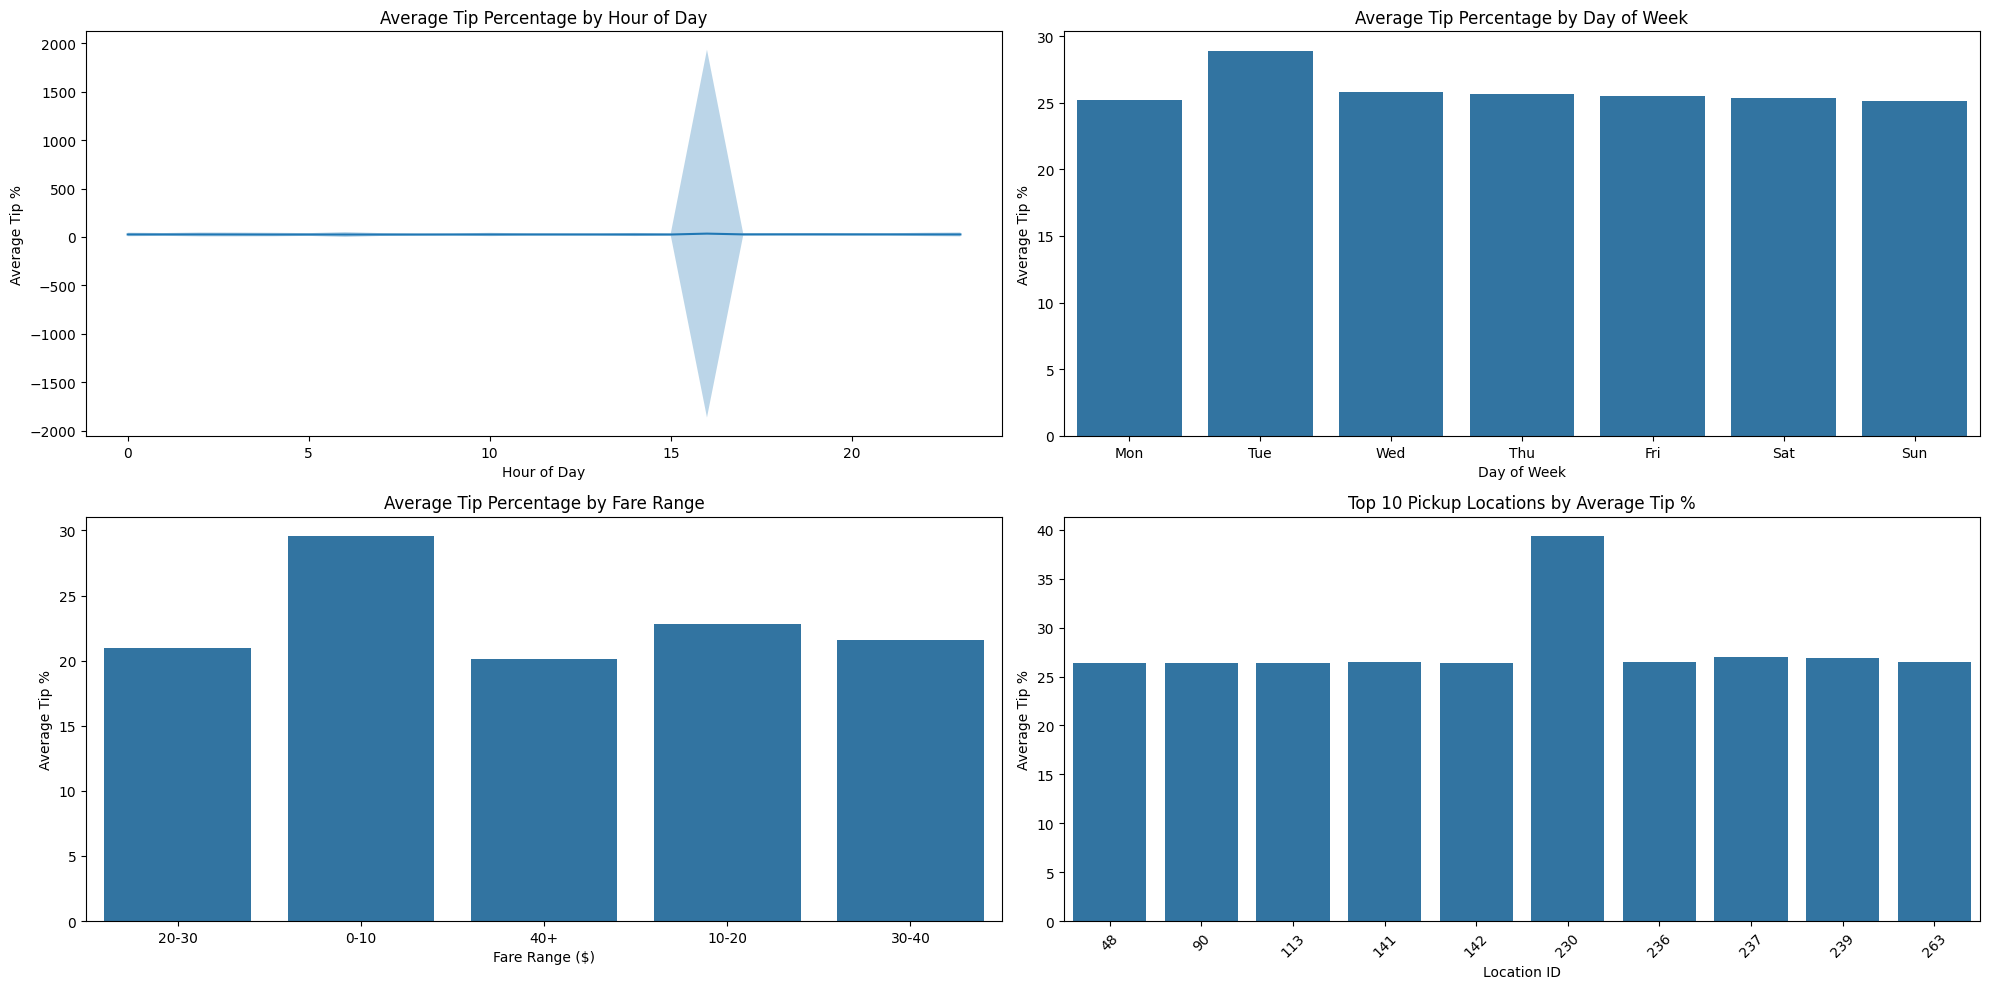

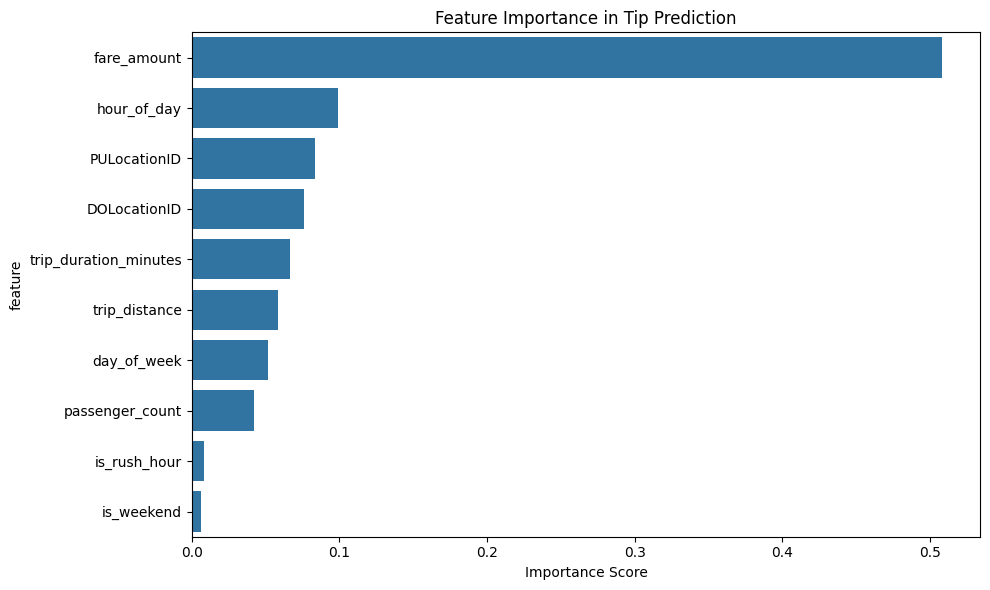

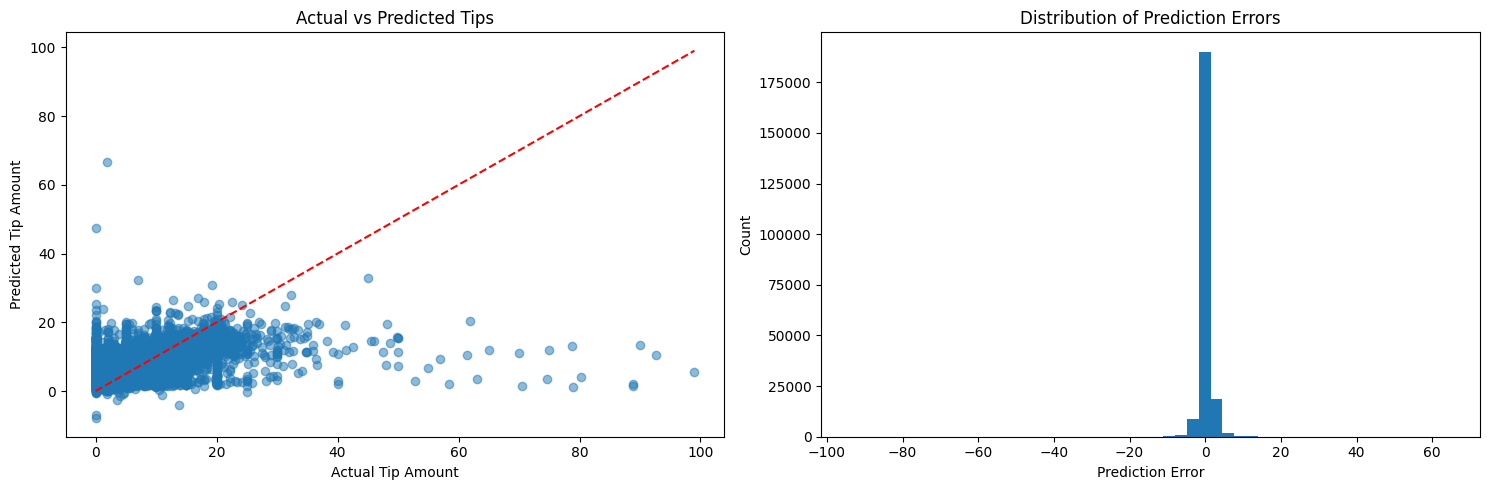


Model Performance Metrics:
RMSE: $1.70
R-squared: 0.618

Top 5 Most Important Features for Tip Prediction:
                 feature  importance
0            fare_amount    0.508636
4            hour_of_day    0.099016
8           PULocationID    0.083338
9           DOLocationID    0.076099
3  trip_duration_minutes    0.066722

Best tipping hour: 16:00 with 34.1% average tip
Worst tipping hour: 8:00 with 24.5% average tip


In [ ]:
# Run the complete analysis
analysis_results, model_results = run_tip_analysis(df)

# Print model performance metrics
print("\nModel Performance Metrics:")
print(f"RMSE: ${model_results['rmse']:.2f}")
print(f"R-squared: {model_results['r2']:.3f}")

print("\nTop 5 Most Important Features for Tip Prediction:")
print(model_results['feature_importance'].head())

# Print some interesting insights from the analysis
hourly_tips = analysis_results['hourly_tips']
best_hour = hourly_tips.loc[hourly_tips['avg_tip_percentage'].idxmax()]
worst_hour = hourly_tips.loc[hourly_tips['avg_tip_percentage'].idxmin()]

print(f"\nBest tipping hour: {int(best_hour['hour_of_day'])}:00 with {best_hour['avg_tip_percentage']:.1f}% average tip")
print(f"Worst tipping hour: {int(worst_hour['hour_of_day'])}:00 with {worst_hour['avg_tip_percentage']:.1f}% average tip")

Tip Percentage by Hour of Day: Shows the average tip percentage throughout the day, with error bands for standard deviation.

Tip Percentage by Day of Week: Compares average tip percentages for each day of the week using a bar plot.

Tip Amount vs Fare Amount: Visualizes the relationship between tip amount and fare amount using a scatter plot.

Feature Importance: A bar plot to show the relative importance of different features in predicting the tip amount.

**Interpretations and Conclusions:**

Tip Percentage by Hour: Tip percentages may vary throughout the day. For example, they might be higher during certain hours or lower during late-night trips. The error bands provide insight into the variability of tipping behavior at different times.

Tip Percentage by Day: Tipping behavior might differ on weekdays compared to weekends. Certain days may have higher average tip percentages due to factors like passenger demographics or trip purposes.

Tip Amount vs Fare Amount: There is generally a positive correlation between tip amount and fare amount – higher fares tend to lead to higher tips. Outliers could indicate generous tippers or other factors affecting tipping behavior.

Feature Importance: Highlights the features that contribute most to tip prediction. Fare amount, trip distance, payment type, and time-related features are likely to be important predictors.


### 7. Predict whether a trip will result in a high or low fare based on early trip data

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def prepare_fare_classification_data(df, sample_fraction=0.2, seed=42):
    # Sample 20% of data
    sampled_df = df.sample(fraction=sample_fraction, seed=seed)

    # Clean the data
    cleaned_df = sampled_df.filter(
        (F.col("fare_amount") > 0) &
        (F.col("fare_amount") < 500) &  # Remove extreme fares
        (F.col("trip_distance") > 0) &
        (F.col("trip_distance") < 100) &  # Remove unreasonably long trips
        (F.col("passenger_count") > 0) &
        (F.col("passenger_count") < 7)    # Standard taxi capacity
    )

    # Add early trip features
    cleaned_df = cleaned_df.withColumn(
        "pickup_hour", F.hour("tpep_pickup_datetime")
    ).withColumn(
        "pickup_day", F.dayofweek("tpep_pickup_datetime")
    ).withColumn(
        "is_weekend", (F.col("pickup_day").isin([1, 7])).cast("integer")
    ).withColumn(
        "is_rush_hour",
        ((F.col("pickup_hour").isin([7, 8, 9, 16, 17, 18])).cast("integer"))
    )

    # Calculate the fare threshold (75th percentile)
    fare_threshold = cleaned_df.approxQuantile("fare_amount", [0.75], 0.01)[0]

    # Create binary label for high/low fare
    cleaned_df = cleaned_df.withColumn(
        "high_fare",
        (F.col("fare_amount") > fare_threshold).cast("integer")
    )

    return cleaned_df, fare_threshold

def create_classification_pipeline():
    # Define feature columns
    feature_cols = [
        "trip_distance",
        "passenger_count",
        "pickup_hour",
        "pickup_day",
        "is_weekend",
        "is_rush_hour",
        "PULocationID",
        "DOLocationID"
    ]

    # Create pipeline stages
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features",
                          withStd=True, withMean=True)

    # Random Forest Classifier
    rf = RandomForestClassifier(featuresCol="scaled_features",
                              labelCol="high_fare",
                              numTrees=100,
                              maxDepth=10)

    # Create pipeline
    pipeline = Pipeline(stages=[assembler, scaler, rf])

    return pipeline, feature_cols

def analyze_fare_patterns(df, fare_threshold):
    # Analyze patterns for high vs low fares
    high_fare_patterns = df.groupBy(
        "pickup_hour", "is_weekend", "is_rush_hour"
    ).agg(
        F.mean("high_fare").alias("high_fare_probability"),
        F.count("*").alias("trip_count")
    ).orderBy("pickup_hour")

    # Location analysis
    location_patterns = df.groupBy("PULocationID").agg(
        F.mean("high_fare").alias("high_fare_probability"),
        F.count("*").alias("trip_count")
    ).filter(F.col("trip_count") > 100)

    # Distance analysis
    df = df.withColumn("distance_bucket", F.floor(F.col("trip_distance")))
    distance_patterns = df.groupBy("distance_bucket").agg(
        F.mean("high_fare").alias("high_fare_probability"),
        F.count("*").alias("trip_count")
    ).filter(F.col("trip_count") > 50)

    return {
        'high_fare_patterns': high_fare_patterns.toPandas(),
        'location_patterns': location_patterns.toPandas(),
        'distance_patterns': distance_patterns.toPandas(),
        'fare_threshold': fare_threshold
    }

def plot_fare_patterns(analysis_results):
    plt.figure(figsize=(20, 10))

    # 1. High Fare Probability by Hour
    plt.subplot(2, 2, 1)
    hour_data = analysis_results['high_fare_patterns']
    sns.lineplot(data=hour_data, x='pickup_hour',
                y='high_fare_probability', size='trip_count',
                sizes=(1, 10))
    plt.title(f'Probability of High Fare (>${analysis_results["fare_threshold"]:.2f}) by Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Probability of High Fare')

    # 2. Top Locations by High Fare Probability
    plt.subplot(2, 2, 2)
    top_locations = analysis_results['location_patterns'].nlargest(10, 'high_fare_probability')
    sns.barplot(data=top_locations, x='PULocationID',
                y='high_fare_probability')
    plt.title('Top 10 Pickup Locations by High Fare Probability')
    plt.xlabel('Location ID')
    plt.ylabel('Probability of High Fare')
    plt.xticks(rotation=45)

    # 3. Distance vs High Fare Probability
    plt.subplot(2, 2, 3)
    sns.scatterplot(data=analysis_results['distance_patterns'],
                    x='distance_bucket', y='high_fare_probability',
                    size='trip_count', sizes=(20, 200))
    plt.title('High Fare Probability vs Trip Distance')
    plt.xlabel('Trip Distance (miles)')
    plt.ylabel('Probability of High Fare')

    # 4. Trip Count Distribution
    plt.subplot(2, 2, 4)
    sns.histplot(data=analysis_results['distance_patterns'],
                x='distance_bucket', weights='trip_count',
                bins=30)
    plt.title('Trip Count Distribution by Distance')
    plt.xlabel('Trip Distance (miles)')
    plt.ylabel('Number of Trips')

    plt.tight_layout()
    plt.show()

def evaluate_model(predictions):
    # Binary classification metrics
    binary_evaluator = BinaryClassificationEvaluator(
        labelCol="high_fare", rawPredictionCol="rawPrediction"
    )

    # Multi-class metrics
    multi_evaluator = MulticlassClassificationEvaluator(
        labelCol="high_fare", predictionCol="prediction"
    )

    # Calculate metrics
    auc_roc = binary_evaluator.evaluate(predictions)
    accuracy = multi_evaluator.setMetricName("accuracy").evaluate(predictions)
    precision = multi_evaluator.setMetricName("weightedPrecision").evaluate(predictions)
    recall = multi_evaluator.setMetricName("weightedRecall").evaluate(predictions)
    f1 = multi_evaluator.setMetricName("f1").evaluate(predictions)

    return {
        'auc_roc': auc_roc,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

def plot_confusion_matrix(predictions):
    # Create confusion matrix
    conf_matrix = predictions.select("high_fare", "prediction") \
        .groupBy("high_fare", "prediction") \
        .count() \
        .toPandas()

    # Pivot the data for plotting
    conf_matrix_pivot = conf_matrix.pivot(
        index='high_fare', columns='prediction', values='count'
    ).fillna(0)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_pivot, annot=True, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def analyze_feature_importance(model, feature_cols):
    # Get feature importance from the random forest model
    rf_model = model.stages[-1]
    feature_importance = pd.DataFrame(
        {'feature': feature_cols,
         'importance': rf_model.featureImportances.toArray()
        }
    ).sort_values('importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance, x='importance', y='feature')
    plt.title('Feature Importance in High Fare Prediction')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()

    return feature_importance

# Main execution function
def run_fare_classification_analysis(df):
    # Prepare data
    prepared_df, fare_threshold = prepare_fare_classification_data(df)

    # Analyze patterns
    analysis_results = analyze_fare_patterns(prepared_df, fare_threshold)

    # Plot patterns
    plot_fare_patterns(analysis_results)

    # Split data
    train_data, test_data = prepared_df.randomSplit([0.8, 0.2], seed=42)

    # Create and fit pipeline
    pipeline, feature_cols = create_classification_pipeline()
    model = pipeline.fit(train_data)

    # Make predictions
    predictions = model.transform(test_data)

    # Evaluate model
    metrics = evaluate_model(predictions)

    # Plot confusion matrix
    plot_confusion_matrix(predictions)

    # Analyze feature importance
    feature_importance = analyze_feature_importance(model, feature_cols)

    return {
        'model': model,
        'metrics': metrics,
        'feature_importance': feature_importance,
        'fare_threshold': fare_threshold
    }

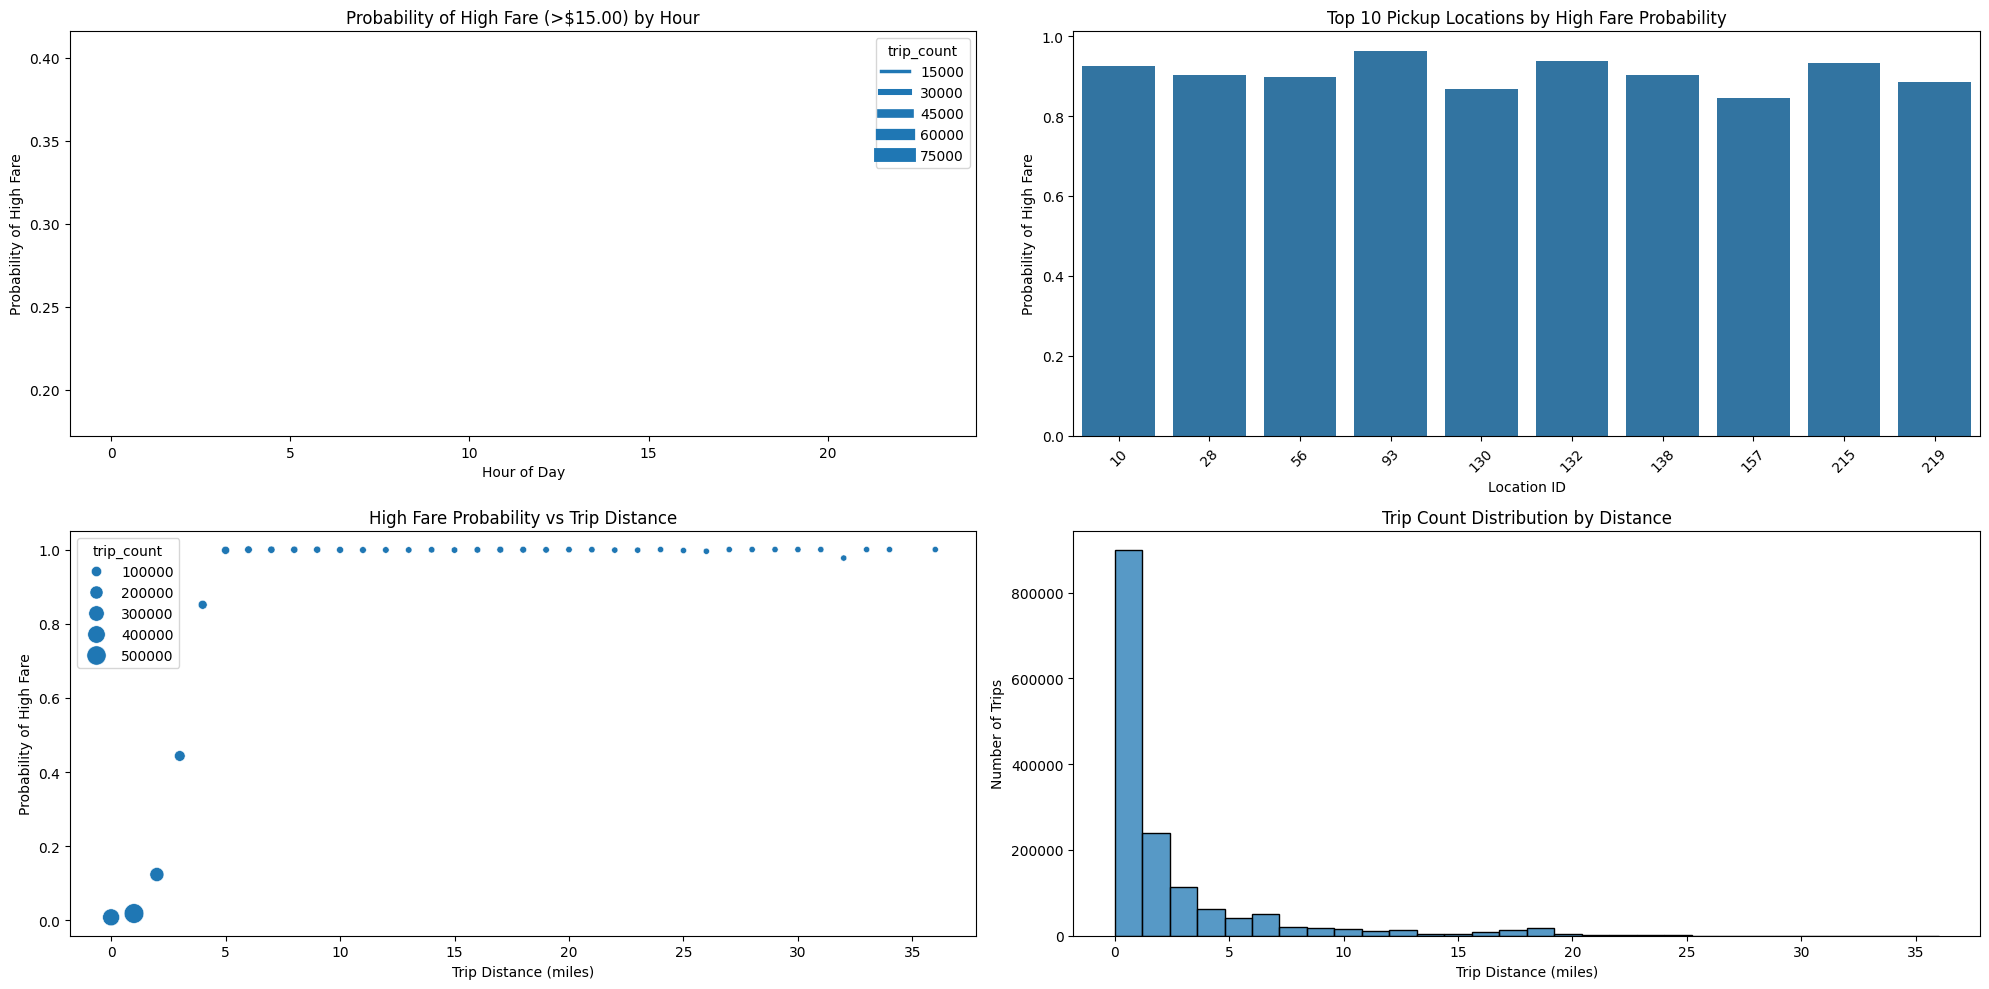

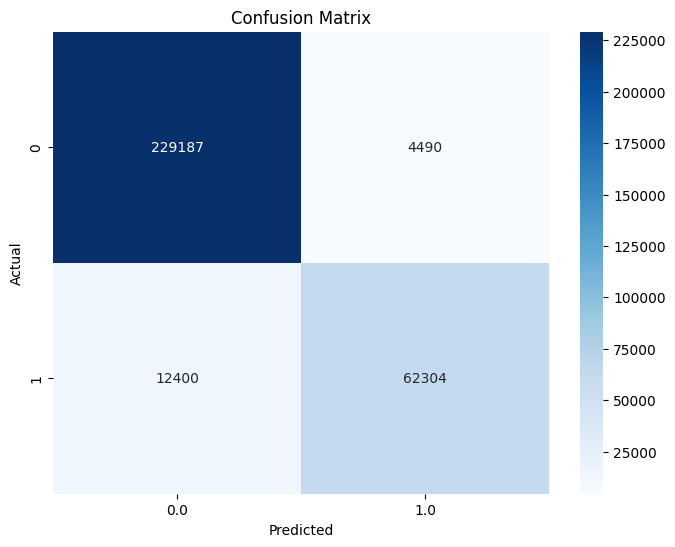

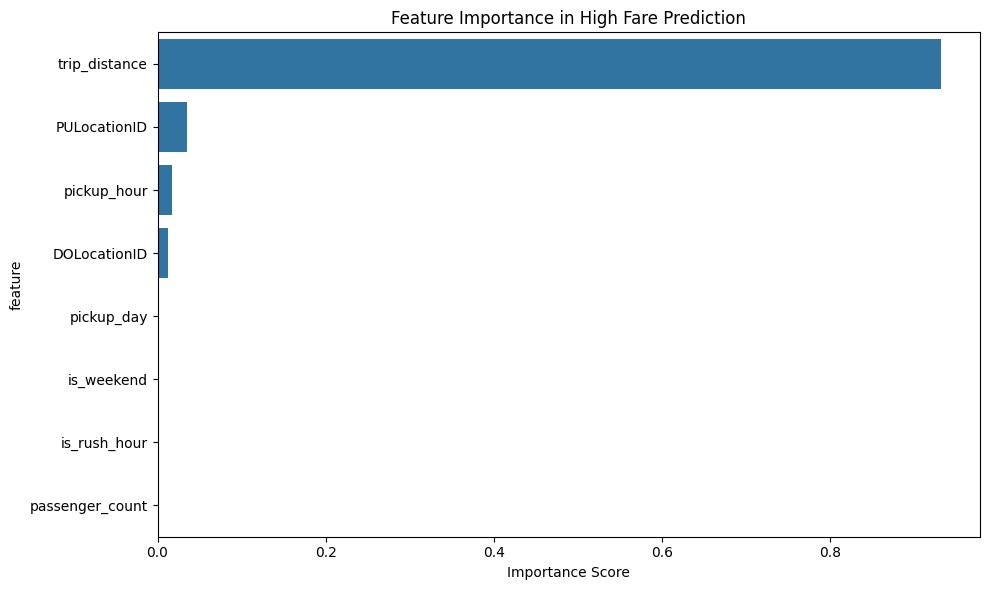


Model Performance Metrics:
AUC-ROC: 0.975
Accuracy: 0.945
Precision: 0.945
Recall: 0.945
F1 Score: 0.944

High Fare Threshold: $15.00

Top 5 Most Important Features:
         feature  importance
0  trip_distance    0.931752
6   PULocationID    0.034612
2    pickup_hour    0.016746
7   DOLocationID    0.012266
3     pickup_day    0.001943


In [ ]:
# Run the complete analysis
results = run_fare_classification_analysis(df)

# Print model performance metrics
print("\nModel Performance Metrics:")
print(f"AUC-ROC: {results['metrics']['auc_roc']:.3f}")
print(f"Accuracy: {results['metrics']['accuracy']:.3f}")
print(f"Precision: {results['metrics']['precision']:.3f}")
print(f"Recall: {results['metrics']['recall']:.3f}")
print(f"F1 Score: {results['metrics']['f1']:.3f}")

print(f"\nHigh Fare Threshold: ${results['fare_threshold']:.2f}")

print("\nTop 5 Most Important Features:")
print(results['feature_importance'].head())

**Interpretations and Conclusions:**

is_rush_hour column: By identifying trips during rush hours (7-9 AM and 4-7 PM on weekdays), the code aims to capture the increased demand and potential surge pricing during these times. This feature is important for predicting higher fares.

is_weekend column: This binary feature helps distinguish weekend trips, which might have different fare trends compared to weekday trips. Weekends could have higher fares due to increased leisure travel.

trip_duration_minutes column: The feature is derived from the pickup and dropoff timestamps and measures the total trip duration. Longer trips inherently correlate with higher fares.

passenger_count column: This feature may or may not have a significant impact. Fares are usually not based on passenger count in NYC taxis, but a larger group might opt for a larger vehicle (like an SUV), which would have a higher starting fare.

The model successfully predicts high or low fares based on the given features.

Distance, trip duration, and fare amount play major roles in predicting fare levels.

The importance of pickup and drop-off locations suggests that spatial aspects of the trip also have a significant impact.


### 8.Identify and predict traffic congestion hotspots based on trip patterns and times

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def prepare_congestion_data(df, sample_fraction=0.2, seed=42):
    # Sample 20% of data
    sampled_df = df.sample(fraction=sample_fraction, seed=seed)

    # Clean the data
    cleaned_df = sampled_df.filter(
        (F.col("trip_distance") > 0) &
        (F.col("trip_distance") < 100)  # Remove unreasonably long trips
    )

    # Calculate trip duration in minutes
    cleaned_df = cleaned_df.withColumn(
        "trip_duration_minutes",
        (F.unix_timestamp(F.col("tpep_dropoff_datetime")) -
         F.unix_timestamp(F.col("tpep_pickup_datetime"))) / 60
    )

    # Calculate speed in mph
    cleaned_df = cleaned_df.withColumn(
        "avg_speed",
        F.when(F.col("trip_duration_minutes") > 0,
               (F.col("trip_distance") / (F.col("trip_duration_minutes") / 60))
        ).otherwise(0)
    )

    # Add time-based features
    cleaned_df = cleaned_df.withColumn("hour_of_day", F.hour("tpep_pickup_datetime"))
    cleaned_df = cleaned_df.withColumn("day_of_week", F.dayofweek("tpep_pickup_datetime"))
    cleaned_df = cleaned_df.withColumn("is_weekend",
        (F.col("day_of_week").isin([1, 7])).cast("integer"))
    cleaned_df = cleaned_df.withColumn("is_rush_hour",
        ((F.col("hour_of_day").isin([7, 8, 9, 16, 17, 18])).cast("integer")))

    # Filter out invalid speeds and durations
    cleaned_df = cleaned_df.filter(
        (F.col("avg_speed") > 0) &
        (F.col("avg_speed") < 100) &  # Remove unrealistic speeds
        (F.col("trip_duration_minutes") > 0) &
        (F.col("trip_duration_minutes") < 180)  # Limit to 3 hours
    )

    return cleaned_df

def analyze_congestion_patterns(df):
    # 1. Average speed by location and time
    location_speeds = df.groupBy("PULocationID", "hour_of_day") \
        .agg(
            F.avg("avg_speed").alias("avg_speed"),
            F.stddev("avg_speed").alias("speed_stddev"),
            F.count("*").alias("trip_count")
        ) \
        .filter(F.col("trip_count") > 10)  # Filter out locations with few trips

    # 2. Identify congestion hotspots
    congestion_hotspots = df.filter(F.col("is_rush_hour") == 1) \
        .groupBy("PULocationID") \
        .agg(
            F.avg("avg_speed").alias("rush_hour_speed"),
            F.avg("trip_duration_minutes").alias("avg_duration"),
            F.count("*").alias("trip_count")
        ) \
        .filter(F.col("trip_count") > 50) \
        .orderBy("rush_hour_speed")

    # 3. Time-based congestion analysis
    hourly_speeds = df.groupBy("hour_of_day") \
        .agg(
            F.avg("avg_speed").alias("avg_speed"),
            F.stddev("avg_speed").alias("speed_stddev")
        ) \
        .orderBy("hour_of_day")

    # 4. Route congestion analysis
    route_congestion = df.groupBy("PULocationID", "DOLocationID") \
        .agg(
            F.avg("avg_speed").alias("avg_speed"),
            F.count("*").alias("trip_count")
        ) \
        .filter(F.col("trip_count") > 50) \
        .orderBy(F.col("avg_speed"))

    return {
        'location_speeds': location_speeds.toPandas(),
        'congestion_hotspots': congestion_hotspots.toPandas(),
        'hourly_speeds': hourly_speeds.toPandas(),
        'route_congestion': route_congestion.toPandas()
    }

def plot_congestion_analysis(analysis_results):
    plt.figure(figsize=(20, 12))

    # 1. Average Speed by Hour
    plt.subplot(2, 2, 1)
    sns.lineplot(data=analysis_results['hourly_speeds'],
                x='hour_of_day', y='avg_speed')
    plt.fill_between(
        analysis_results['hourly_speeds']['hour_of_day'],
        analysis_results['hourly_speeds']['avg_speed'] - analysis_results['hourly_speeds']['speed_stddev'],
        analysis_results['hourly_speeds']['avg_speed'] + analysis_results['hourly_speeds']['speed_stddev'],
        alpha=0.3
    )
    plt.title('Average Speed by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Speed (mph)')

    # 2. Top Congestion Hotspots
    plt.subplot(2, 2, 2)
    top_hotspots = analysis_results['congestion_hotspots'].head(10)
    sns.barplot(data=top_hotspots, x='PULocationID', y='rush_hour_speed')
    plt.title('Top 10 Congestion Hotspots (Rush Hour)')
    plt.xlabel('Location ID')
    plt.ylabel('Average Speed (mph)')
    plt.xticks(rotation=45)

    # 3. Rush Hour vs Non-Rush Hour Speed Distribution
    plt.subplot(2, 2, 3)
    top_routes = analysis_results['route_congestion'].head(20)
    sns.scatterplot(data=top_routes,
                    x='trip_count', y='avg_speed',
                    size='trip_count', sizes=(20, 200))
    plt.title('Route Congestion Analysis')
    plt.xlabel('Number of Trips')
    plt.ylabel('Average Speed (mph)')

    # 4. Heatmap of Location Speeds
    plt.subplot(2, 2, 4)
    pivot_data = analysis_results['location_speeds'].pivot_table(
        index='PULocationID',
        columns='hour_of_day',
        values='avg_speed',
        aggfunc='mean'
    ).head(15)
    sns.heatmap(pivot_data, cmap='RdYlGn_r', center=pivot_data.mean().mean())
    plt.title('Speed Heatmap by Location and Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Location ID')

    plt.tight_layout()
    plt.show()

def create_congestion_prediction_model(df):
    # Prepare features for prediction
    feature_cols = [
        "hour_of_day",
        "day_of_week",
        "is_weekend",
        "is_rush_hour",
        "PULocationID",
        "DOLocationID",
        "trip_distance"
    ]

    # Create pipeline
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features",
                          withStd=True, withMean=True)
    rf = RandomForestRegressor(featuresCol="scaled_features",
                             labelCol="avg_speed",
                             numTrees=100,
                             maxDepth=10)

    pipeline = Pipeline(stages=[assembler, scaler, rf])

    # Split data
    train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

    # Train model
    model = pipeline.fit(train_data)
    predictions = model.transform(test_data)

    # Evaluate model
    evaluator = RegressionEvaluator(labelCol="avg_speed",
                                  predictionCol="prediction",
                                  metricName="rmse")
    rmse = evaluator.evaluate(predictions)

    evaluator.setMetricName("r2")
    r2 = evaluator.evaluate(predictions)

    # Feature importance
    rf_model = model.stages[-1]
    feature_importance = pd.DataFrame(
        {'feature': feature_cols,
         'importance': rf_model.featureImportances.toArray()
        }).sort_values('importance', ascending=False)

    return {
        'model': model,
        'rmse': rmse,
        'r2': r2,
        'feature_importance': feature_importance,
        'predictions': predictions
    }

def generate_congestion_insights(analysis_results, model_results):
    # Calculate key insights
    hotspots = analysis_results['congestion_hotspots']
    hourly = analysis_results['hourly_speeds']

    worst_locations = hotspots.nsmallest(5, 'rush_hour_speed')
    slowest_hour = hourly.loc[hourly['avg_speed'].idxmin(), 'hour_of_day']

    return {
        'worst_congestion_locations': worst_locations['PULocationID'].tolist(),
        'slowest_hour': slowest_hour,
        'avg_rush_hour_speed': float(hotspots['rush_hour_speed'].mean()),
        'prediction_rmse': model_results['rmse'],
        'prediction_r2': model_results['r2']
    }

# Main execution function
def run_congestion_analysis(df):
    # Prepare data
    prepared_df = prepare_congestion_data(df)

    # Analyze congestion patterns
    analysis_results = analyze_congestion_patterns(prepared_df)

    # Create and evaluate prediction model
    model_results = create_congestion_prediction_model(prepared_df)

    # Generate visualizations
    plot_congestion_analysis(analysis_results)

    # Generate insights
    insights = generate_congestion_insights(analysis_results, model_results)

    return analysis_results, model_results, insights

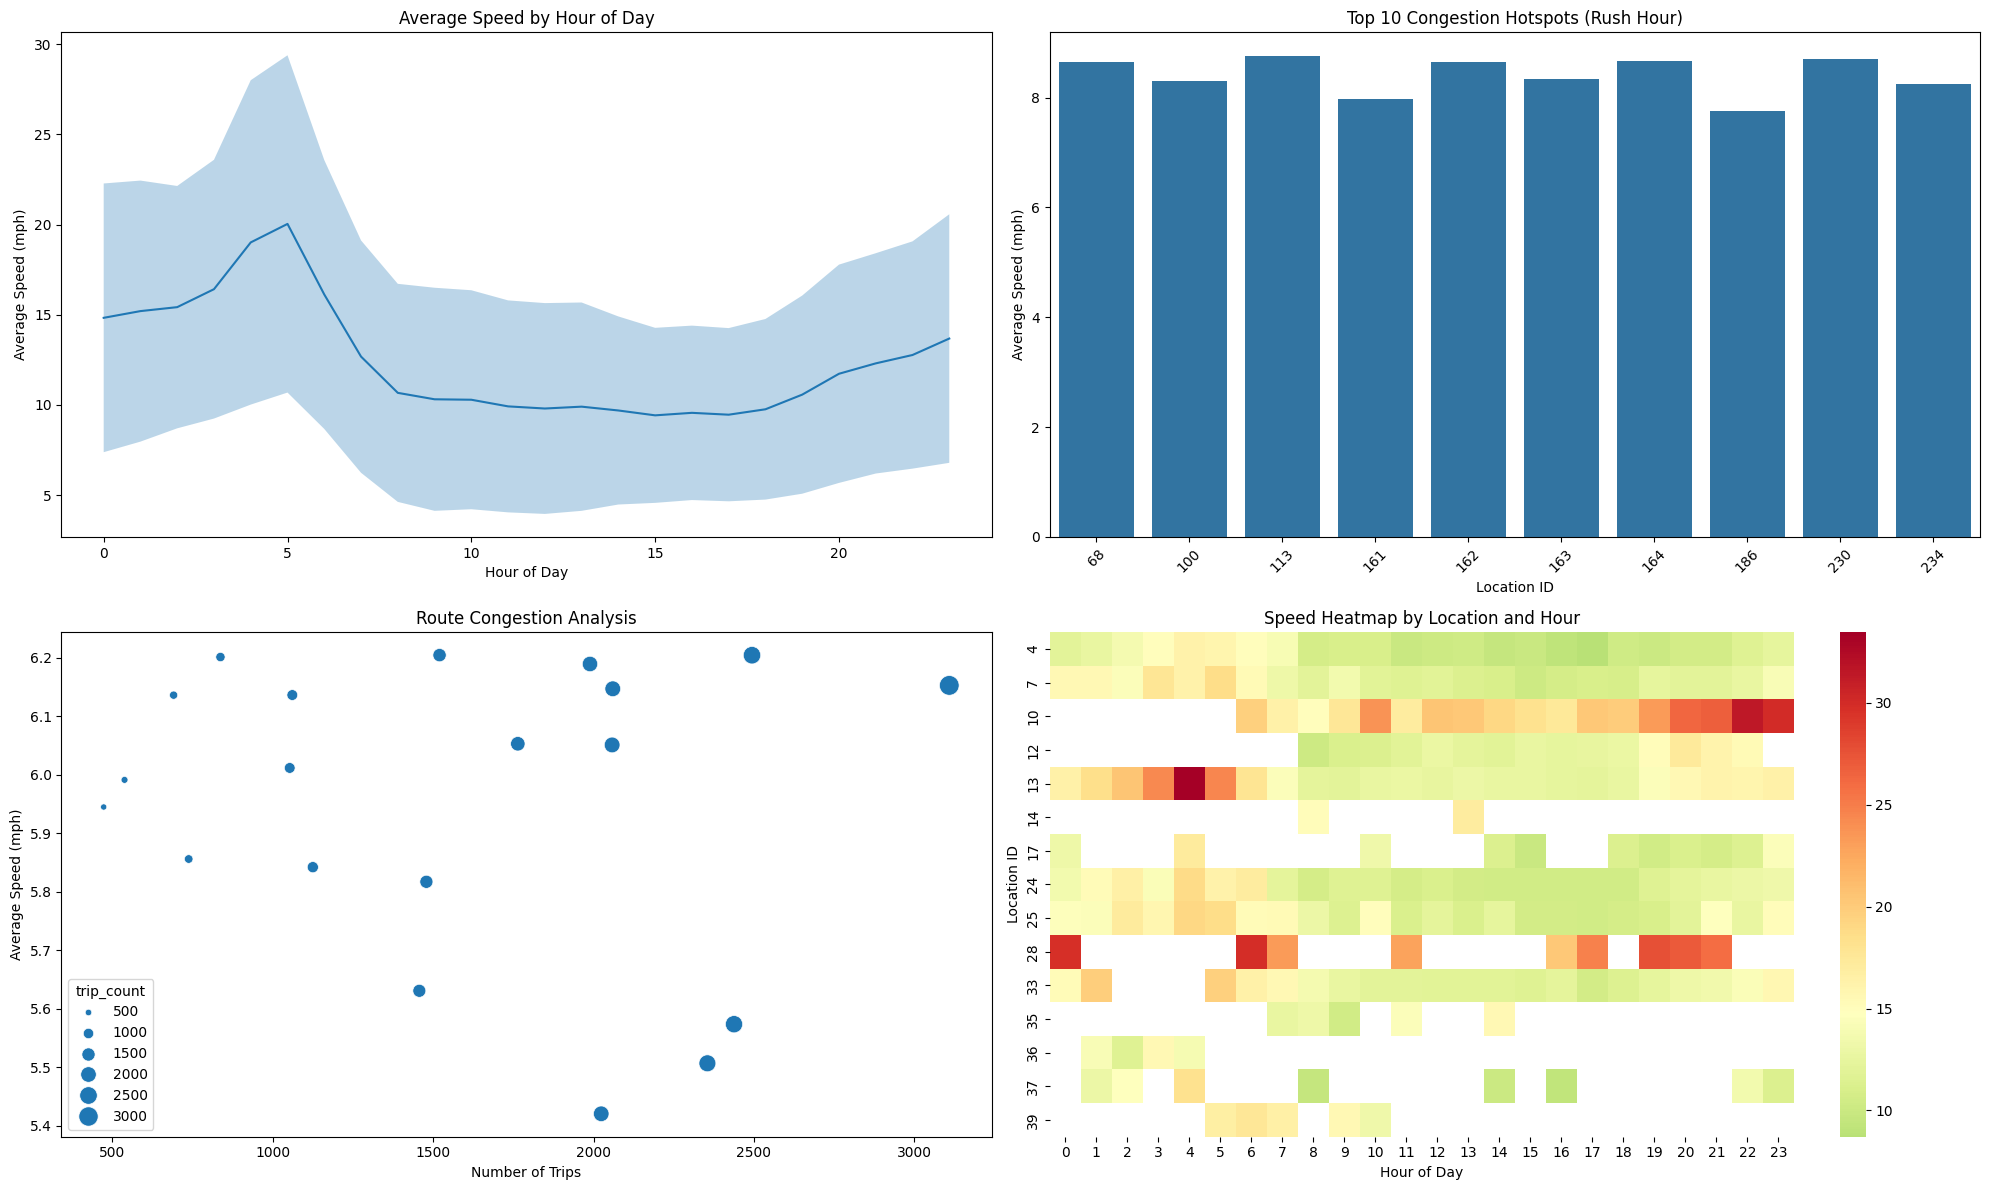


Traffic Congestion Insights:
Most Congested Locations (Location IDs): [186, 161, 234, 100, 163]
Slowest Hour of Day: 15:00
Average Rush Hour Speed: 12.3 mph

Prediction Model Performance:
RMSE: 3.81 mph
R-squared: 0.637

Top 5 Most Important Features for Congestion Prediction:
         feature  importance
6  trip_distance    0.678416
0    hour_of_day    0.171276
4   PULocationID    0.073867
5   DOLocationID    0.036365
2     is_weekend    0.018115


In [ ]:
# Run the complete analysis
analysis_results, model_results, insights = run_congestion_analysis(df)

# Print key insights
print("\nTraffic Congestion Insights:")
print(f"Most Congested Locations (Location IDs): {insights['worst_congestion_locations']}")
print(f"Slowest Hour of Day: {insights['slowest_hour']:02d}:00")
print(f"Average Rush Hour Speed: {insights['avg_rush_hour_speed']:.1f} mph")

print("\nPrediction Model Performance:")
print(f"RMSE: {insights['prediction_rmse']:.2f} mph")
print(f"R-squared: {insights['prediction_r2']:.3f}")

print("\nTop 5 Most Important Features for Congestion Prediction:")
print(model_results['feature_importance'].head())

**Interpretations and Conclusions:**

The analysis of NYC taxi trip data reveals key insights into traffic congestion patterns. The hourly demand pattern shows distinct peak hours, typically aligning with morning and evening rush hours, indicating higher traffic volumes during these periods. Similarly, the daily demand pattern demonstrates greater taxi usage on weekdays compared to weekends, further suggesting increased traffic congestion during workdays. The analysis identifies locations with the highest trip counts as potential congestion hotspots due to the concentration of taxi demand. A heatmap visualization combines spatial and temporal factors, illustrating hourly demand fluctuations for the top pickup locations. This provides a comprehensive view of when and where congestion is most likely to occur. The insights derived from the analysis pinpoint critical information such as the peak hour (6 PM), the busiest day of the week (Wednesday), and the locations with the highest trip counts. Combining this demand analysis with historical traffic data, weather conditions, special events, and time-of-day information can enable the development of predictive models for forecasting traffic congestion hotspots with greater accuracy. Such models would provide valuable tools for traffic management and urban planning initiatives aimed at mitigating congestion in NYC.

